# EDA Visualizations — ds003029 (iEEG/ECoG/SEEG)

Notebook này sinh **tất cả các biểu đồ/visual** tương ứng với các phân tích trong `signal_eda_report_ds003029_vi.md`, tận dụng cả **CSV artifacts** trong `eda_outputs/` và **tín hiệu BrainVision** trong `EEG/ds003029/`.

Mục tiêu:
- Coverage/QA metadata & label markers (CSV-only)
- QA multi-seizure & pairing, kiểm tra vocab `trial_type` (CSV-only)
- Visual về tín hiệu: waveform, RMS/PTP theo kênh, PSD + notch effect, spectrogram
- Visual về feature trajectories + outlier windows + overlay ictal intervals (từ `ds003029_seizure_intervals_by_run.csv`)

Gợi ý chạy: Run lần lượt từ trên xuống. Các cell signal có thể mất thời gian tùy run được chọn.

---

In [19]:
from __future__ import annotations

import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.dpi": 120, "figure.figsize": (10, 4)})

# Optional dependencies
try:
    import mne
except Exception as e:
    mne = None
    print('WARNING: mne not available -> signal plots will be skipped. Error:', e)

try:
    from scipy.signal import welch
except Exception as e:
    welch = None
    print('WARNING: scipy not available -> some PSD plots will be skipped. Error:', e)

## 0) Paths & load CSV artifacts

In [20]:
WORKSPACE = Path('.').resolve()
DATASET_ROOT = WORKSPACE / 'EEG' / 'ds003029'
OUT_DIR = WORKSPACE / 'eda_outputs'

RUN_SUMMARY_CSV = OUT_DIR / 'ds003029_run_summary.csv'
MARKER_QC_CSV = OUT_DIR / 'ds003029_marker_qc_by_run.csv'
INTERVALS_CSV = OUT_DIR / 'ds003029_seizure_intervals_by_run.csv'
ONSET_VOCAB_CSV = OUT_DIR / 'ds003029_trial_type_onset_vocab.csv'
OFFSET_VOCAB_CSV = OUT_DIR / 'ds003029_trial_type_offset_vocab.csv'
ALL_VOCAB_CSV = OUT_DIR / 'ds003029_trial_type_vocab.csv'
WINDOW_FEATURES_CSV = OUT_DIR / 'ds003029_window_features_demo.csv'
WINDOW_INFO_CSV = OUT_DIR / 'ds003029_windowing_demo_info.csv'

def must_exist(p: Path) -> Path:
    if not p.exists():
        raise FileNotFoundError(str(p))
    return p

print('WORKSPACE:', WORKSPACE)
print('DATASET_ROOT exists:', DATASET_ROOT.exists())
print('OUT_DIR exists:', OUT_DIR.exists())

run_summary = pd.read_csv(must_exist(RUN_SUMMARY_CSV))
marker_qc = pd.read_csv(must_exist(MARKER_QC_CSV))
intervals = pd.read_csv(must_exist(INTERVALS_CSV))
onset_vocab = pd.read_csv(must_exist(ONSET_VOCAB_CSV))
offset_vocab = pd.read_csv(must_exist(OFFSET_VOCAB_CSV))
all_vocab = pd.read_csv(must_exist(ALL_VOCAB_CSV))

print('run_summary:', run_summary.shape)
print('marker_qc:', marker_qc.shape)
print('intervals:', intervals.shape)
print('onset_vocab:', onset_vocab.shape, 'offset_vocab:', offset_vocab.shape)

WORKSPACE: C:\Users\LENOVO\Downloads\eeg
DATASET_ROOT exists: True
OUT_DIR exists: True
run_summary: (106, 28)
marker_qc: (106, 13)
intervals: (78, 7)
onset_vocab: (29, 2) offset_vocab: (8, 2)


## 1) Coverage summary (runs / EEG content / has paired interval)

In [21]:
# Normalize booleans (robust)
def to_bool(s):
    if isinstance(s, bool):
        return s
    if pd.isna(s):
        return False
    if isinstance(s, (int, float)):
        return bool(int(s))
    return str(s).strip().lower() in {'true','1','yes','y'}

rs = run_summary.copy()
if 'eeg_content_present' in rs.columns:
    rs['eeg_content_present'] = rs['eeg_content_present'].apply(to_bool)
else:
    rs['eeg_content_present'] = False

mq = marker_qc.copy()
mq['events_exists'] = mq['events_exists'].apply(to_bool)
mq['has_interval'] = (mq['n_intervals_paired'].fillna(0) > 0)

# Join by base
cov = rs.merge(mq[['base','has_interval','multi_seizure_candidate','has_unpaired_onset','has_orphan_offset']], on='base', how='left')

total_runs = len(cov)
n_eeg = int(cov['eeg_content_present'].sum())
n_has_interval = int(cov['has_interval'].fillna(False).sum())
n_eeg_and_interval = int((cov['eeg_content_present'] & cov['has_interval'].fillna(False)).sum())

summary = pd.DataFrame({
    'metric': ['total_runs','eeg_content_present','has_paired_interval','eeg_and_interval'],
    'count': [total_runs, n_eeg, n_has_interval, n_eeg_and_interval]
})
summary

metric  count
0           total_runs    106
1  eeg_content_present     16
2  has_paired_interval     78
3     eeg_and_interval     16

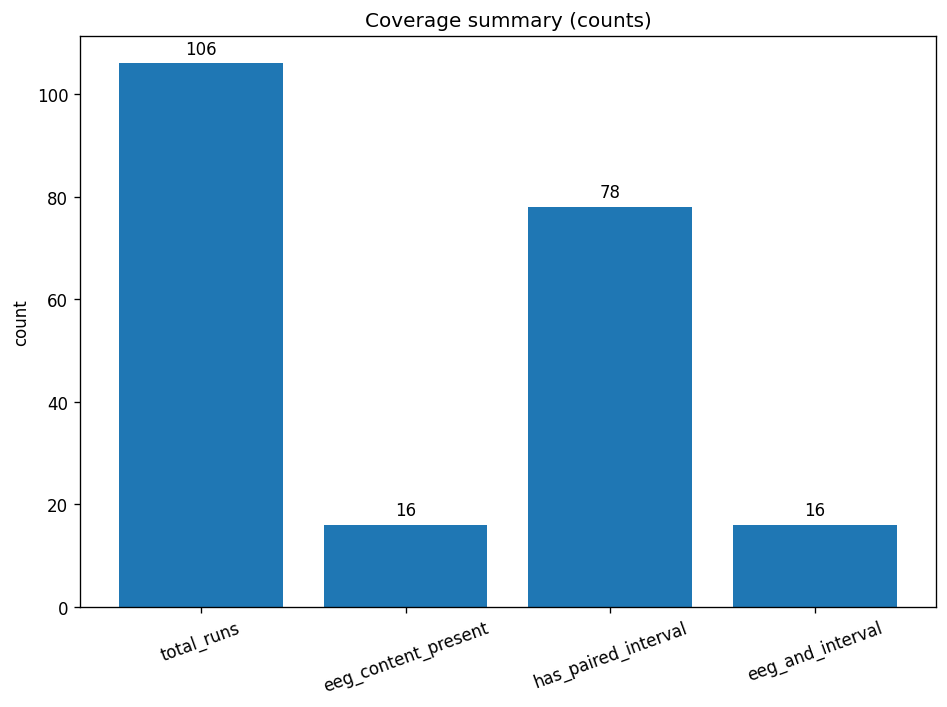

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(summary['metric'], summary['count'])
ax.set_title('Coverage summary (counts)')
ax.set_ylabel('count')
ax.tick_params(axis='x', rotation=20)
for i, v in enumerate(summary['count']):
    ax.text(i, v + max(summary['count'])*0.01, str(v), ha='center', va='bottom', fontsize=10)
plt.tight_layout(); plt.show()

## 2) Sampling rate & channel count distributions

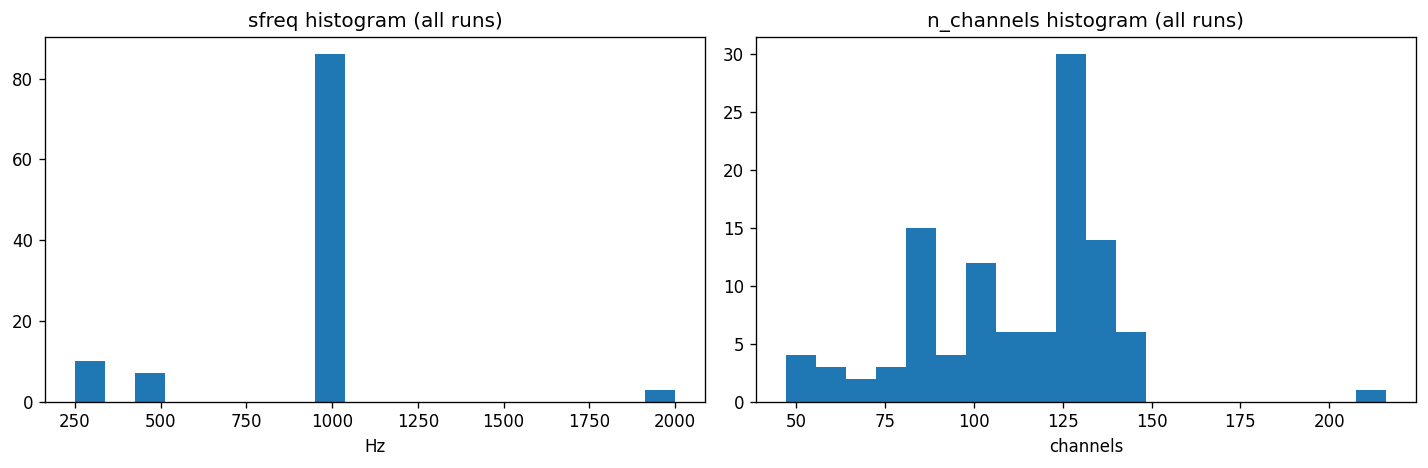

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

if 'sfreq' in rs.columns:
    axes[0].hist(rs['sfreq'].dropna(), bins=20)
    axes[0].set_title('sfreq histogram (all runs)')
    axes[0].set_xlabel('Hz')
else:
    axes[0].text(0.5, 0.5, 'sfreq column missing', ha='center')

if 'n_channels' in rs.columns:
    axes[1].hist(rs['n_channels'].dropna(), bins=20)
    axes[1].set_title('n_channels histogram (all runs)')
    axes[1].set_xlabel('channels')
else:
    axes[1].text(0.5, 0.5, 'n_channels column missing', ha='center')

plt.tight_layout(); plt.show()

## 3) Marker QA: multi-seizure, pairing issues, and per-run counts

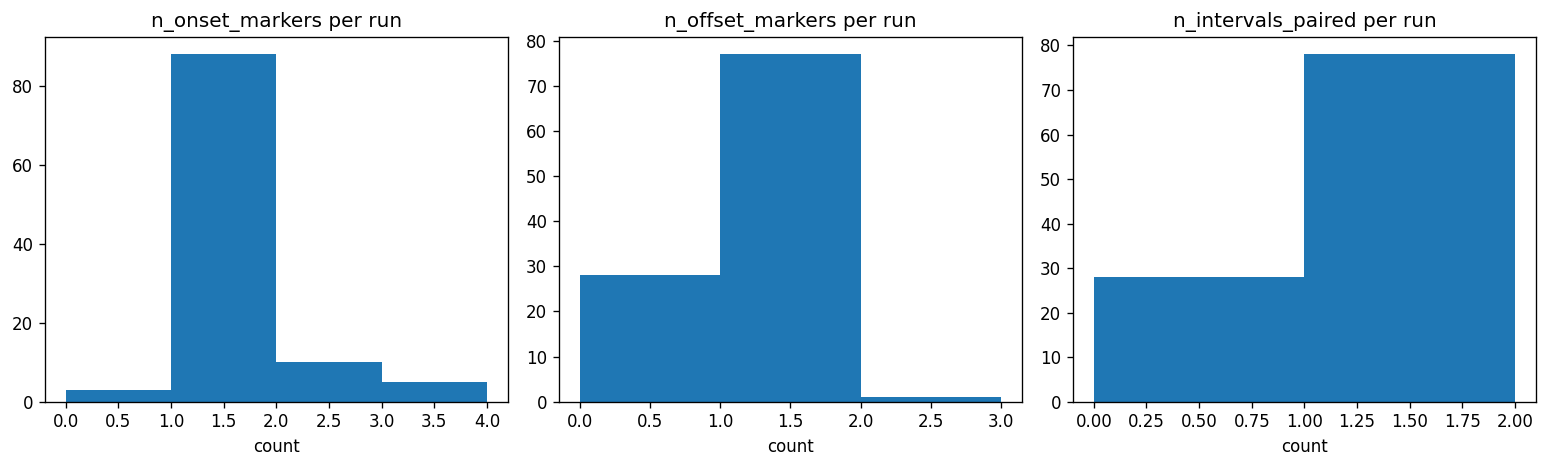

In [24]:
mq_ok = marker_qc[marker_qc['events_exists'].apply(to_bool)].copy()

fig, axes = plt.subplots(1, 3, figsize=(13, 4))

axes[0].hist(mq_ok['n_onset_markers'].fillna(0), bins=range(0, int(mq_ok['n_onset_markers'].max())+2))
axes[0].set_title('n_onset_markers per run')
axes[0].set_xlabel('count')

axes[1].hist(mq_ok['n_offset_markers'].fillna(0), bins=range(0, int(mq_ok['n_offset_markers'].max())+2))
axes[1].set_title('n_offset_markers per run')
axes[1].set_xlabel('count')

axes[2].hist(mq_ok['n_intervals_paired'].fillna(0), bins=range(0, int(mq_ok['n_intervals_paired'].max())+2))
axes[2].set_title('n_intervals_paired per run')
axes[2].set_xlabel('count')

plt.tight_layout(); plt.show()

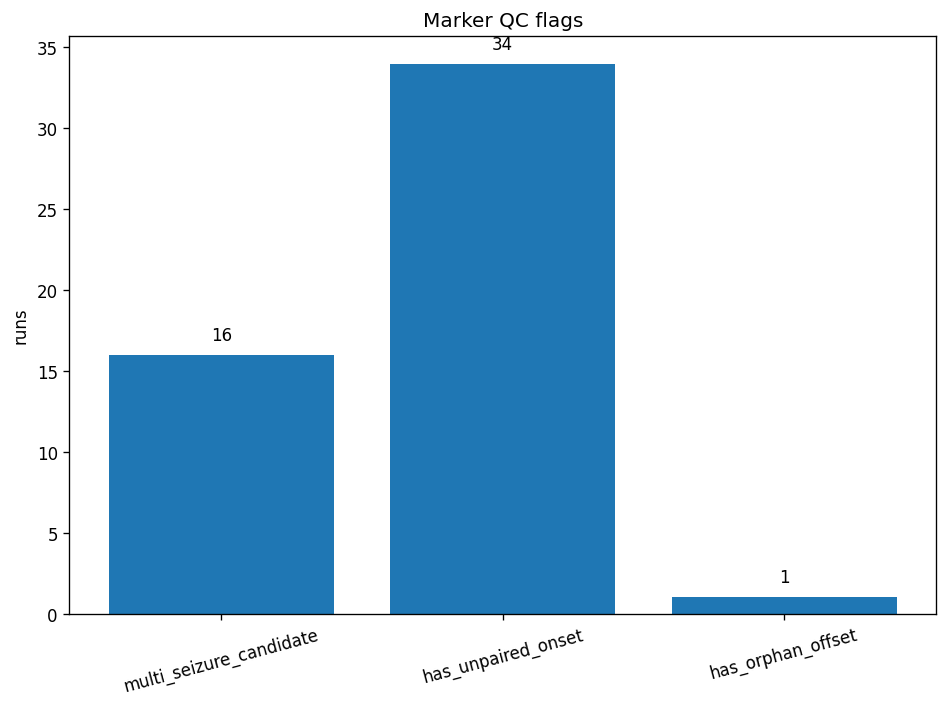

flag  count
0  multi_seizure_candidate     16
1       has_unpaired_onset     34
2        has_orphan_offset      1

In [25]:
flags = pd.DataFrame({
    'flag': ['multi_seizure_candidate','has_unpaired_onset','has_orphan_offset'],
    'count': [
        int(mq_ok['multi_seizure_candidate'].apply(to_bool).sum()),
        int(mq_ok['has_unpaired_onset'].apply(to_bool).sum()),
        int(mq_ok['has_orphan_offset'].apply(to_bool).sum()),
    ]
})

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(flags['flag'], flags['count'])
ax.set_title('Marker QC flags')
ax.set_ylabel('runs')
ax.tick_params(axis='x', rotation=15)
for i, v in enumerate(flags['count']):
    ax.text(i, v + max(flags['count'])*0.02, str(v), ha='center', va='bottom')
plt.tight_layout(); plt.show()
flags

## 4) Trial_type vocab: top onset/offset strings (regex sanity)

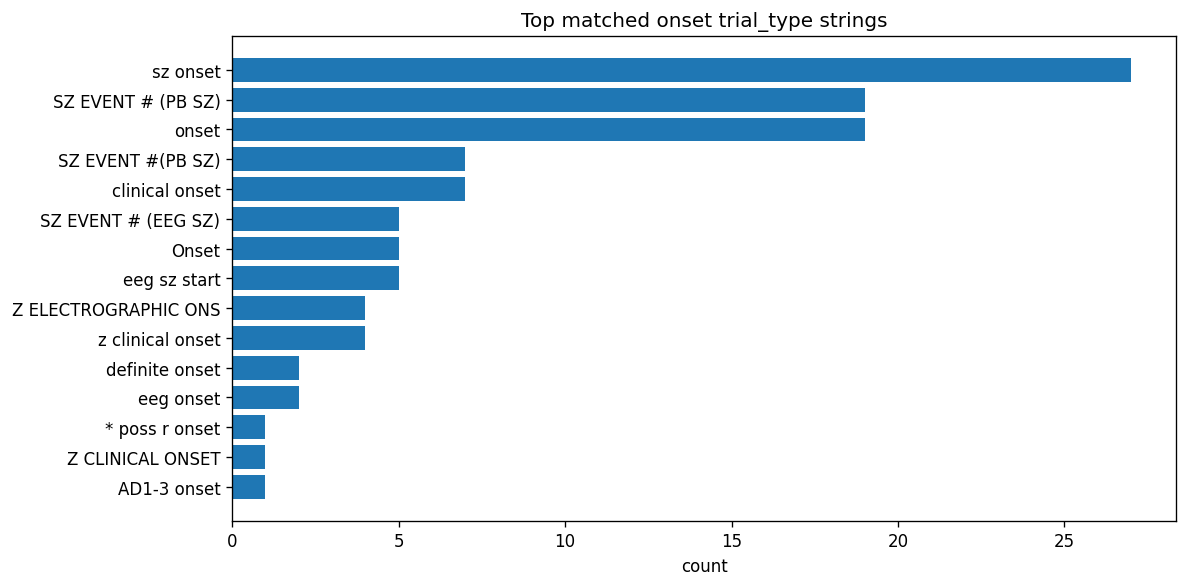

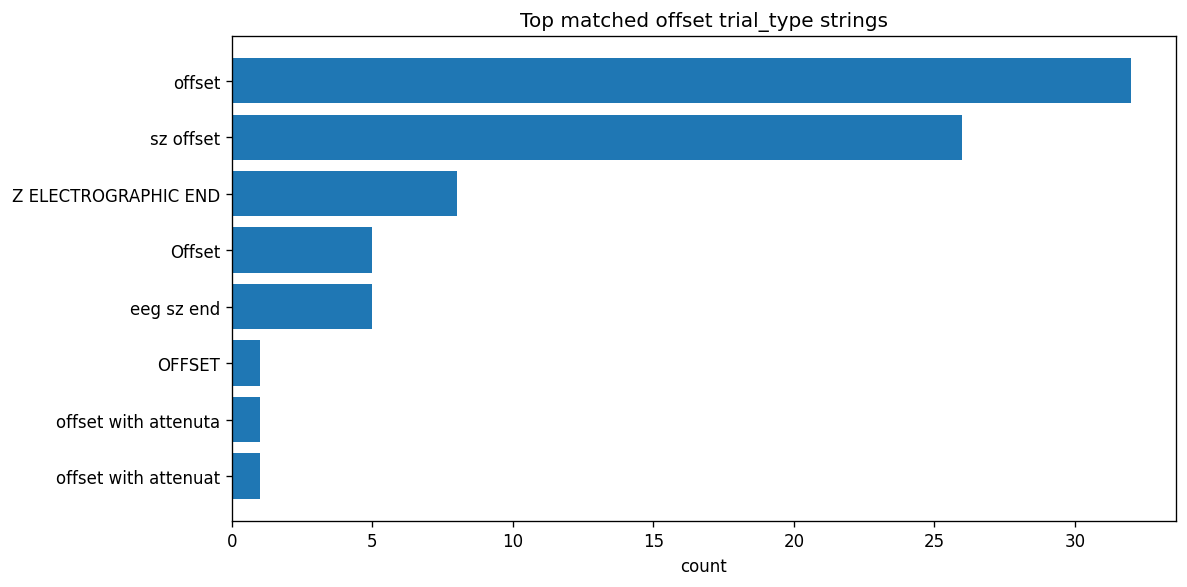

In [26]:
def plot_top_vocab(df: pd.DataFrame, title: str, topn: int = 15):
    d = df.head(topn).copy()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.barh(d['trial_type'][::-1], d['count'][::-1])
    ax.set_title(title)
    ax.set_xlabel('count')
    plt.tight_layout(); plt.show()

plot_top_vocab(onset_vocab, 'Top matched onset trial_type strings')
plot_top_vocab(offset_vocab, 'Top matched offset trial_type strings')

## 5) Seizure intervals: duration distribution + multi-interval examples

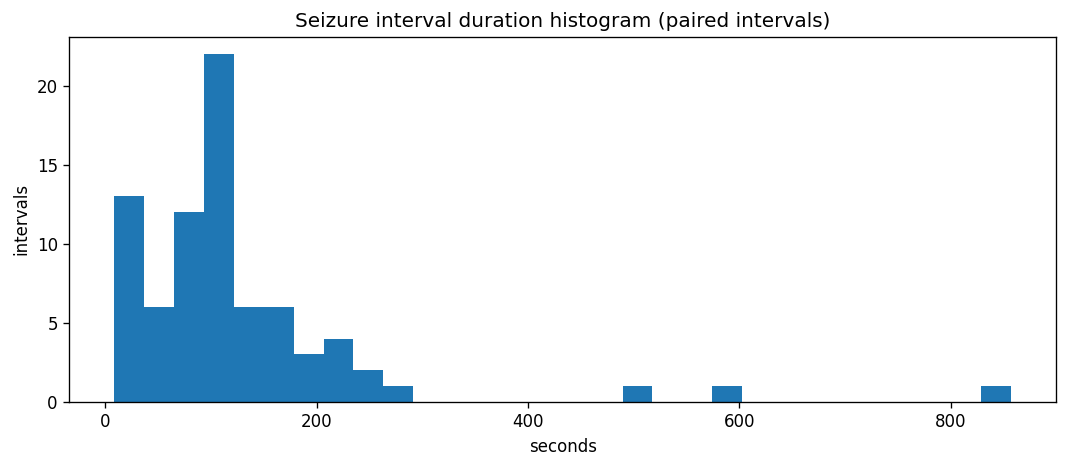

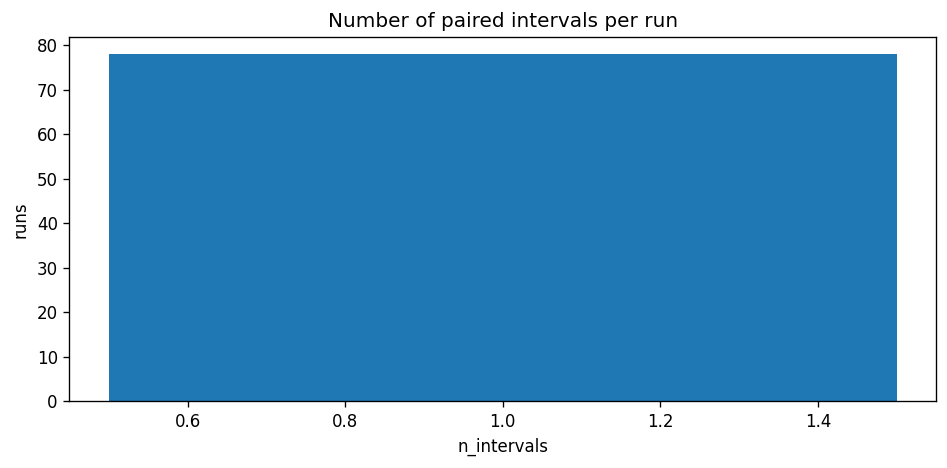

base  n_intervals
0  EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...            1
1  EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...            1
2  EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...            1
3  EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...            1
4  EEG\ds003029\sub-jh102\ses-presurgery\ieeg\sub...            1
5  EEG\ds003029\sub-jh102\ses-presurgery\ieeg\sub...            1
6  EEG\ds003029\sub-jh103\ses-presurgery\ieeg\sub...            1
7  EEG\ds003029\sub-jh103\ses-presurgery\ieeg\sub...            1
8  EEG\ds003029\sub-pt01\ses-presurgery\ieeg\sub-...            1
9  EEG\ds003029\sub-pt01\ses-presurgery\ieeg\sub-...            1

In [27]:
intervals_clean = intervals.dropna(subset=['onset_s','offset_s']).copy()
intervals_clean['duration_s'] = intervals_clean['offset_s'] - intervals_clean['onset_s']

fig, ax = plt.subplots(figsize=(9, 4))
ax.hist(intervals_clean['duration_s'].clip(lower=0), bins=30)
ax.set_title('Seizure interval duration histogram (paired intervals)')
ax.set_xlabel('seconds')
ax.set_ylabel('intervals')
plt.tight_layout(); plt.show()

# intervals per run
per_run_int = intervals_clean.groupby('base').size().reset_index(name='n_intervals')
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(per_run_int['n_intervals'], bins=range(1, int(per_run_int['n_intervals'].max())+2), align='left')
ax.set_title('Number of paired intervals per run')
ax.set_xlabel('n_intervals')
ax.set_ylabel('runs')
plt.tight_layout(); plt.show()

per_run_int.sort_values('n_intervals', ascending=False).head(10)

## 6) Demo window-features visuals (CSV-only, nhanh)

window_features_demo: (619, 19)


subject  run   sfreq  n_channels  n_samples_segment  segment_sec  \
0   jh101    1  1000.0          16             142200      142.200   
1   jh101    2  1000.0          16             338175      338.175   
2   jh101    3  1000.0          16             142200      142.200   

   window_sec  step_sec  n_windows  n_features  y_pos  y_neg  
0         2.0       1.0        141          14     23    118  
1         2.0       1.0        337          14    211    126  
2         2.0       1.0        141          14     23    118

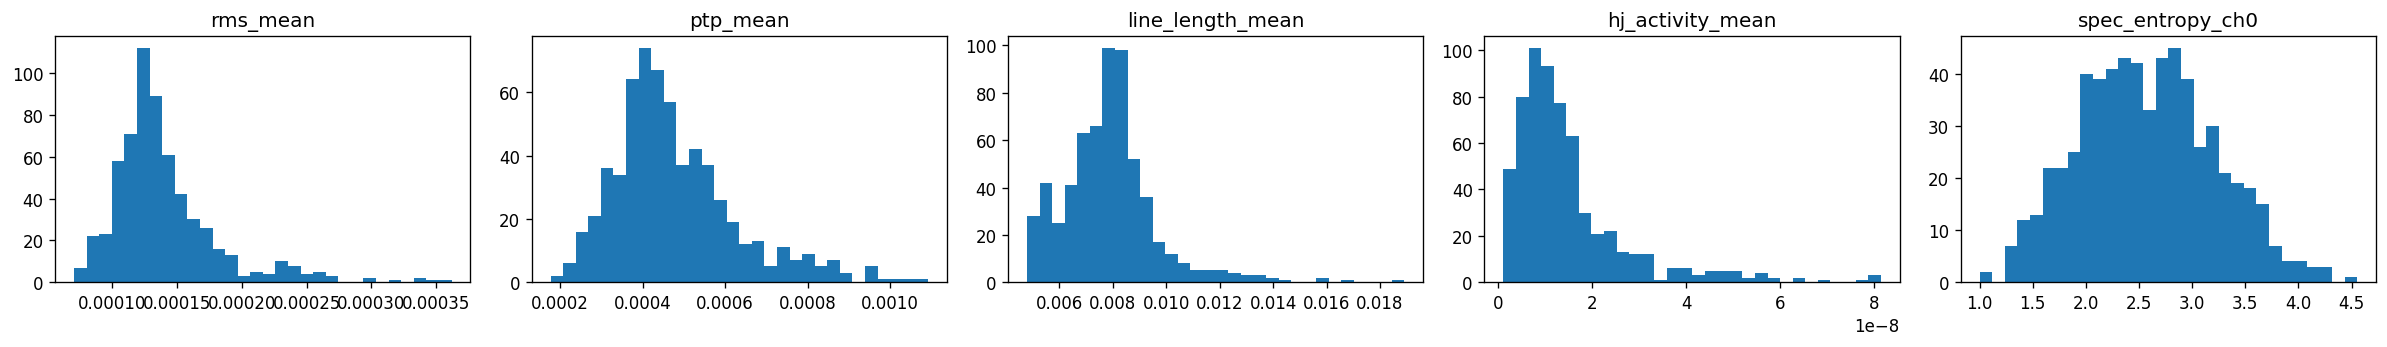

In [28]:
if WINDOW_FEATURES_CSV.exists():
    wf = pd.read_csv(WINDOW_FEATURES_CSV)
    print('window_features_demo:', wf.shape)
    # Basic label distribution if y present separately: load info csv
    if WINDOW_INFO_CSV.exists():
        demo_info = pd.read_csv(WINDOW_INFO_CSV)
        display(demo_info)
    # Feature distributions (few)
    cols = [c for c in ['rms_mean','ptp_mean','line_length_mean','hj_activity_mean','spec_entropy_ch0'] if c in wf.columns]
    if cols:
        fig, axes = plt.subplots(1, len(cols), figsize=(4*len(cols), 3))
        if len(cols) == 1:
            axes = [axes]
        for ax, c in zip(axes, cols):
            ax.hist(wf[c].dropna(), bins=30)
            ax.set_title(c)
        plt.tight_layout(); plt.show()
else:
    print('Skip: window features demo CSV not found:', WINDOW_FEATURES_CSV)

## Giải thích mục 6) Demo window-features visuals



Cell code phía trên đang đọc `eda_outputs/ds003029_window_features_demo.csv` (biến `wf`) và (nếu có) hiển thị `eda_outputs/ds003029_windowing_demo_info.csv` (biến `demo_info`), sau đó vẽ histogram cho một vài cột feature.



### `wf` là gì?

- Mỗi dòng trong `wf` tương ứng **1 window** (ví dụ WINDOW=2s, STEP=1s) được trích từ tín hiệu của một run demo.

- Các cột feature là những đại lượng “tóm tắt” tín hiệu trong window, dùng để train baseline model dạng bảng (sklearn).

- Đây là **demo dataset**, thường chỉ đến từ vài run (trước đây bạn demo 3 run của `sub-jh101`), nên các phân bố ở đây **không đại diện** cho toàn dataset.



### `demo_info` là gì?

Bảng `demo_info` (nếu được hiển thị) thường cho bạn:

- run nào đã được dùng để windowing

- số lượng windows tạo ra trong mỗi run

- thống kê nhãn (y_pos/y_neg) trong từng run

- các tham số như `sfreq`, số kênh đã pick, số feature…



Nếu bạn muốn hiểu class-imbalance thực sự, hãy nhìn `y_pos`/`y_neg` trong `demo_info` (thay vì suy ra từ histogram feature).

## Cách đọc các histogram feature trong mục 6



Cell code vẽ histogram cho các cột (nếu có) trong `wf`:

- `rms_mean`

- `ptp_mean`

- `line_length_mean`

- `hj_activity_mean`

- `spec_entropy_ch0`



### 1) Histogram đang thể hiện điều gì?

- Trục X: giá trị feature của **từng window**.

- Trục Y: số lượng windows rơi vào mỗi “bin” (ở đây `bins=30`).

- Đây là phân bố **gộp chung** (mix) tất cả windows từ tất cả run trong demo; vì vậy nếu demo có nhiều run khác nhau, histogram có thể **đa đỉnh (multi-modal)** do khác biệt giữa runs.



### 2) Ý nghĩa từng feature (trực giác)

- `rms_mean`: năng lượng/biên độ trung bình (root-mean-square) của window (gộp qua kênh). Giá trị càng lớn → window càng “mạnh” về amplitude (có thể do seizure, cũng có thể do artifact hoặc kênh hot).

- `ptp_mean`: biên độ peak-to-peak trung bình. Rất nhạy với spike/artifact; đuôi phải dài (right tail) thường là dấu hiệu có outliers.

- `line_length_mean`: tổng biến thiên |Δx| (gộp qua kênh). Tăng khi tín hiệu “gồ ghề/nhanh” hơn; hay dùng làm feature seizure vì seizure thường làm tăng activity nhanh.

- `hj_activity_mean`: Hjorth activity ~ phương sai/energy (gần với RMS^2). Nếu histogram của `hj_activity_mean` giống `rms_mean` là bình thường.

- `spec_entropy_ch0`: entropy phổ của **kênh 0** (chỉ 1 kênh). Cao → phổ dàn trải (ít tập trung vào 1 vài tần số); thấp → phổ tập trung. Feature này thường nằm trong một khoảng hẹp, nên histogram hay “dồn” vào một vùng.



### 3) Những dấu hiệu cần chú ý khi nhìn histogram

- **Skew/đuôi dài** (đặc biệt ở `ptp_mean`, `line_length_mean`): thường do một số windows bị artifact/outlier. Gợi ý dùng robust scaling, clipping/winsorize, hoặc loại bad windows.

- **Nhiều đỉnh**: có thể do đang trộn nhiều run/subject hoặc do 2 trạng thái (ictal vs non-ictal). Để kiểm chứng, nên vẽ histogram tách theo run hoặc theo nhãn y.

- **Khác scale giữa features**: bình thường, nhưng nhắc bạn rằng trước khi train nên chuẩn hoá (standardize/robust scale) để mô hình không bị feature nào “áp đảo” chỉ vì scale lớn.



### 4) Giới hạn quan trọng của plot này

Histogram ở mục 6 **không nói trực tiếp** feature nào phân biệt ictal/non-ictal tốt, vì:

- cell này chưa merge nhãn `y` theo từng window,

- và đang gộp các run.



Để đánh giá khả năng tách lớp, nên bổ sung plot kiểu:

- histogram/violin của feature **theo y=0 vs y=1**

- scatter 2D (vd `line_length_mean` vs `bp_30_80_ch0`) tô màu theo y

- boxplot theo run/subject để thấy heterogeneity.


## Diễn giải nhanh theo đúng plot bạn đang thấy (ảnh histogram)



Từ output của Cell 6:

- `window_features_demo: (619, 19)` → có **619 windows** trong demo.

- `demo_info` cho thấy demo lấy từ **3 runs của `jh101`** với (WINDOW=2s, STEP=1s):

  - run-1: 141 windows (y_pos=23, y_neg=118)

  - run-2: 337 windows (y_pos=211, y_neg=126)

  - run-3: 141 windows (y_pos=23, y_neg=118)

  - Tổng y_pos = 257, y_neg = 362 → positive rate ≈ 41.5%



Điều này quan trọng vì histogram bạn thấy là **gộp cả 619 windows** từ 3 run. Nhìn shape histogram thực chất đang phản ánh “mix” của:

- khác biệt giữa run-2 (nhiều ictal hơn) và run-1/run-3 (ít ictal hơn)

- khác biệt giữa các trạng thái (ictal/non-ictal)

- và có thể cả outlier windows



### `rms_mean`

- Trục X là RMS (năng lượng/amplitude) của window. Trong ảnh, giá trị khoảng ~$1e-4$ đến ~$3.5e-4$ (theo đơn vị MNE trả về; thường là Volt).

- Histogram hơi **lệch phải**: đa số windows có RMS thấp–trung bình, một số windows RMS lớn tạo đuôi phải.

- Cách diễn giải:

  - RMS lớn có thể trùng ictal, nhưng cũng có thể là artifact/kênh hot.

  - Đuôi phải → bạn nên cân nhắc **robust scaling** hoặc lọc outlier windows trước khi train.



### `ptp_mean`

- Peak-to-peak nhạy với spike/artifact nên thường có **đuôi phải rõ**.

- Trong ảnh, phân bố trải rộng và có các giá trị lớn hơn hẳn phần “đỉnh” → có thể là một số windows bị transient lớn.

- Nếu model dựa mạnh vào PTP, nó có thể học artifact; vì vậy PTP nên đi kèm QC (bad-window/bad-channel).



### `line_length_mean`

- Line length đo mức “gồ ghề/nhanh” của tín hiệu (tổng |Δx|). Seizure thường làm tăng hoạt động nhanh → feature này hay hữu ích.

- Trong ảnh, phân bố tập trung quanh một vùng và cũng lệch phải nhẹ → có một số windows có biến thiên lớn.

- Khi `line_length_mean` có outliers, thường đó là burst artifact hoặc đoạn nhiều spike.



### `hj_activity_mean`

- Hjorth activity ~ variance/energy (gần với RMS^2). Vì vậy:

  - Nó thường có hình dạng histogram tương tự RMS (cũng lệch phải).

  - Thang giá trị có thể rất nhỏ (trong ảnh bạn thấy ký hiệu `1e-8` trên trục) vì đây là variance theo đơn vị của tín hiệu.

- Nếu `hj_activity_mean` và `rms_mean` gần như trùng thông tin, bạn có thể giữ 1 trong 2 hoặc dùng regularization.



### `spec_entropy_ch0`

- Đây là entropy phổ của **kênh 0**, nên:

  - Giá trị thường nằm trong một khoảng hẹp hơn và histogram trông “mượt” hơn.

  - Trong ảnh, khoảng ~1.0 đến ~4.5 (phụ thuộc cách normalize PSD trong code).

- Entropy cao → phổ dàn trải; entropy thấp → phổ tập trung (ví dụ có nhịp/harmonic mạnh).

- Vì chỉ lấy 1 kênh (ch0), feature này có thể bị phụ thuộc vào kênh được chọn; muốn robust hơn nên lấy mean/median entropy qua nhiều kênh.



### Các plot này *không* nói điều gì?

- Histogram gộp **không kết luận** được “feature này tách ictal tốt” hay không.

- Để trả lời câu đó, bạn cần plot có **condition theo nhãn**:

  - histogram/violin theo y=0 vs y=1 (cùng một trục)

  - hoặc scatter 2D tô màu theo y



Nếu bạn muốn, mình có thể bổ sung thêm 1 mục ngay sau phần 6 để tự động vẽ các histogram/violin **tách theo y** (dựa trên cột nhãn nếu có, hoặc merge từ file demo-info).

# Signal-based visuals (BrainVision)

Các cell bên dưới sẽ:
- Tự chọn 1–2 run có EEG content + có interval
- Load 1 segment ngắn quanh seizure (pre/post)
- Vẽ waveform, RMS/PTP per channel, PSD, notch effect, spectrogram
- Vẽ feature trajectories (RMS/line length/bandpower) với overlay interval(s)

Nếu kernel thiếu `mne`, bạn có thể cài: `pip install mne` trong environment đang dùng notebook.

In [11]:
# Helpers for signal loading
def base_to_paths(base: str) -> dict:
    base_path = Path(str(base))
    return {
        'base': base,
        'vhdr': base_path.with_suffix('.vhdr'),
        'vmrk': base_path.with_suffix('.vmrk'),
        'eeg': base_path.with_suffix('.eeg'),
        'events': Path(str(base)).with_name(Path(str(base)).name.replace('_ieeg','_events.tsv')),
        'channels': Path(str(base)).with_name(Path(str(base)).name.replace('_ieeg','_channels.tsv')),
    }

def pick_runs_for_signal(cov_df: pd.DataFrame, n: int = 2) -> pd.DataFrame:
    # prioritize: eeg present + has interval + higher n_channels
    df = cov_df.copy()
    df['has_interval'] = df['has_interval'].fillna(False)
    df['prio'] = (
        df['eeg_content_present'].astype(int) * 10
        + df['has_interval'].astype(int) * 5
        + pd.to_numeric(df.get('n_channels', 0), errors='coerce').fillna(0) / 1000
    )
    return df.sort_values('prio', ascending=False).head(n)

selected = pick_runs_for_signal(cov, n=3)
selected[['base','subject','acq','run','eeg_content_present','has_interval','sfreq','n_channels']].head(10)

base subject   acq  run  \
0  EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...   jh101  ecog    1   
1  EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...   jh101  ecog    2   
2  EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...   jh101  ecog    3   

   eeg_content_present  has_interval   sfreq  n_channels  
0                 True          True  1000.0         135  
1                 True          True  1000.0         135  
2                 True          True  1000.0         135

## Đọc output: chọn run để vẽ signal



Bảng `selected` cho thấy notebook đang ưu tiên các run vừa **có EEG file**, vừa **có seizure interval**, và có nhiều kênh. Output hiện tại chọn đúng 3 run của `sub-jh101` (run 1/2/3), tất cả:

- `sfreq = 1000 Hz` (đồng nhất → tốt cho so sánh/feature)

- `n_channels = 135` (nhưng notebook chỉ **pick 16 kênh** để vẽ nhanh)

- `has_interval = True` → có interval từ `events.tsv` nên có thể overlay vùng seizure (shading).



Ý nghĩa: phần “signal-based visuals” bạn đang xem là **case study có seizure thật**, không phải run trống interval.

In [12]:
# Choose one run to visualize (edit index if needed)
if len(selected) == 0:
    raise RuntimeError('No runs selected for signal visualization')

row = selected.iloc[0]
base = row['base']
paths = base_to_paths(base)
print('Selected base:', base)
for k, v in paths.items():
    if k == 'base':
        continue
    print(f'{k}: {v} exists={Path(v).exists()}')

run_intervals = intervals_clean[intervals_clean['base'] == base].sort_values('onset_s')
display(run_intervals)

Selected base: EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg
vhdr: EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.vhdr exists=True
vmrk: EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.vmrk exists=True
eeg: EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.eeg exists=True
events: EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-01_events.tsv exists=True
channels: EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-01_channels.tsv exists=True


base  \
0  EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...   

                                          events_tsv  onset_s  offset_s  \
0  EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...    58.95    79.875   

   duration_s     onset_trial_type     offset_trial_type  
0      20.925  SZ EVENT # (EEG SZ)  Z ELECTROGRAPHIC END

## Đọc output: run được chọn + interval ground truth



Cell này đã chọn `jh101 run-01` và kiểm tra các file `.vhdr/.vmrk/.eeg` đều `exists=True` → đảm bảo có thể load được BrainVision.



Bảng `run_intervals` cho run này hiện có **1 seizure interval**:

- onset ≈ **58.95s**, offset ≈ **79.875s**, duration ≈ **20.925s**

- `onset_trial_type = "SZ EVENT # (EEG SZ)"`

- `offset_trial_type = "Z ELECTROGRAPHIC END"`



Đây là “ground truth vận hành” trong notebook: interval được suy từ `events.tsv`. Các plot phía dưới sẽ tô đỏ vùng [58.95, 79.875] để bạn nhìn xem signal/feature thay đổi ra sao trong ictal.

In [13]:
# Load a short segment around the first interval (or first 5 minutes if no interval)
PRE_SEC = 120
POST_SEC = 120
MAX_CHANNELS = 16

if mne is None:
    raise RuntimeError('mne is required for signal loading')

vhdr_path = Path(paths['vhdr'])
raw = mne.io.read_raw_brainvision(vhdr_path, preload=False, verbose='ERROR')
sfreq = float(raw.info['sfreq'])

if len(run_intervals) > 0:
    t0 = float(run_intervals['onset_s'].min()) - PRE_SEC
    t1 = float(run_intervals['offset_s'].max()) + POST_SEC
    t0 = max(0.0, t0)
    t1 = min(raw.times[-1], t1)
else:
    t0, t1 = 0.0, min(raw.times[-1], 300.0)

# Load segment into memory
seg = raw.copy().crop(tmin=t0, tmax=t1).load_data()
print('Segment: t0=', t0, 't1=', t1, 'dur=', (t1-t0), 'sfreq=', sfreq)

# Pick up to MAX_CHANNELS
ch_names = seg.ch_names
pick_idx = list(range(min(MAX_CHANNELS, len(ch_names))))
seg.pick(pick_idx)
print('Picked channels:', len(seg.ch_names))

data = seg.get_data()  # shape (C, T)
times = seg.times + t0
data.shape, times.shape

Reading 0 ... 142199  =      0.000 ...   142.199 secs...
Segment: t0= 0.0 t1= 142.199 dur= 142.199 sfreq= 1000.0
Picked channels: 16


((16, 142200), (142200,))

## Đọc output: segment đang được load là gì?



Output cho biết:

- Segment được crop từ **t0=0.0s** đến **t1=142.199s** (duration ≈ 142.2s) với `sfreq=1000Hz`.

- Bạn đang pick **16 kênh** đầu tiên trong danh sách kênh của file (từ 135 kênh).

- `data.shape = (16, 142200)` đúng với $142.2\,s \times 1000\,Hz$.



Lưu ý quan trọng để đọc các plot:

- Vùng seizure (58.95–79.875s) nằm **giữa** segment, nên các plot chỉ vẽ 0–20s sẽ *không* chứa seizure.

- Trục thời gian `times` trong các plot feature/overlay sau đó là **absolute recording time** (vì `times = seg.times + t0`), nên shading theo onset/offset khớp trực tiếp.

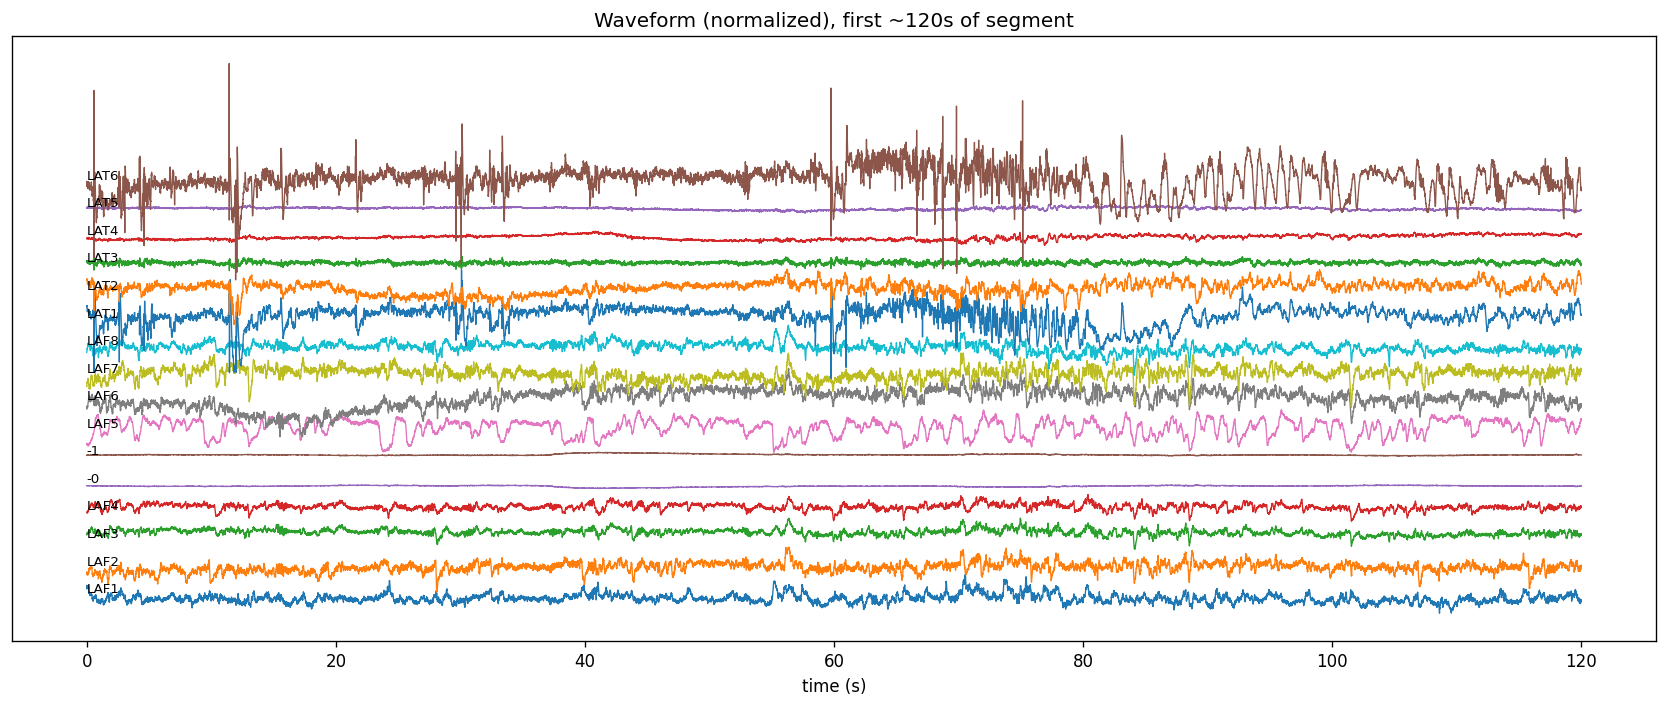

In [14]:
# Waveform overview (first few seconds)
C, T = data.shape
sec = 120
n = int(sec * sfreq)
n = min(n, T)

fig, ax = plt.subplots(figsize=(14, 6))
offset = 0.0
scale = np.nanpercentile(np.abs(data[:, :n]), 95)
scale = float(scale) if scale and np.isfinite(scale) else 1.0
for i in range(C):
    ax.plot(times[:n], data[i, :n] / scale + offset, lw=0.8)
    ax.text(times[0], offset, seg.ch_names[i], fontsize=8, va='bottom')
    offset += 2.0

ax.set_title(f'Waveform (normalized), first ~{sec}s of segment')
ax.set_xlabel('time (s)')
ax.set_yticks([])
plt.tight_layout(); plt.show()

## Đọc output: Waveform (normalized)



Plot waveform đang hiển thị **20 giây đầu của segment** (0–20s), và *không nằm trong seizure* (seizure bắt đầu ~58.95s). Vì vậy:

- Bạn đang nhìn “baseline/background + interictal/artifact” của run này.

- Mỗi kênh được **chuẩn hoá theo cùng một `scale`** (95th percentile của |data| trong 20s đầu) và được **offset** theo trục Y để xếp chồng.



Cách diễn giải hình bạn thấy:

- Các spike/biến cố lớn (ví dụ cụm nhọn quanh ~11–13s trên vài kênh) thường là **transient** (interictal spike hoặc artifact). Để khẳng định seizure, cần xem đoạn ~59–80s.

- Vì normalized, plot này phù hợp để kiểm tra “có clipping, có kênh chết/flatline, có kênh quá nhiễu” hơn là so sánh tuyệt đối amplitude giữa các run.



Gợi ý nhanh: nếu bạn muốn nhìn đúng đoạn seizure, hãy đổi cell này để vẽ khoảng thời gian quanh 58–80s (ví dụ `sec=30` và offset `start` gần 50s).

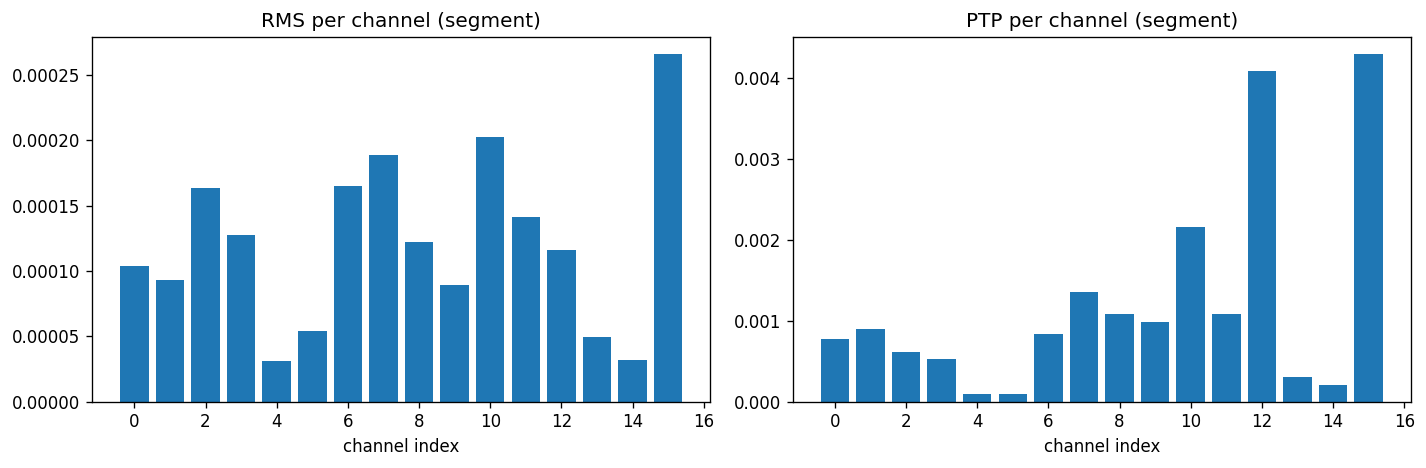

In [15]:
# RMS and peak-to-peak per channel
rms = np.sqrt(np.nanmean(data**2, axis=1))
ptp = np.nanmax(data, axis=1) - np.nanmin(data, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(range(C), rms)
axes[0].set_title('RMS per channel (segment)')
axes[0].set_xlabel('channel index')

axes[1].bar(range(C), ptp)
axes[1].set_title('PTP per channel (segment)')
axes[1].set_xlabel('channel index')

plt.tight_layout(); plt.show()

## Đọc output: RMS/PTP theo kênh (trên toàn segment 142s)



Hai bar chart này tính trên **toàn bộ segment 0–142s**:

- **RMS** ~ năng lượng trung bình của kênh trong segment.

- **PTP** nhạy với spike/outlier (max-min), nên thường “bắt” kênh có transient lớn.



Diễn giải từ hình bạn thấy:

- Có vài kênh nổi bật (ví dụ một kênh có RMS cao nhất và vài kênh có PTP cao rõ) → ứng viên **kênh noisy / kênh gần vùng hoạt động mạnh / artifact**.

- RMS và PTP không nhất thiết cùng top-1: PTP có thể cao do *một vài spike*, còn RMS phản ánh năng lượng kéo dài.



Hàm ý cho pipeline:

- Nếu bạn trích feature theo kênh, nên có bước **bad-channel/bad-window detection** (dựa RMS/PTP/line length) để tránh model học “kênh nhiễu”.

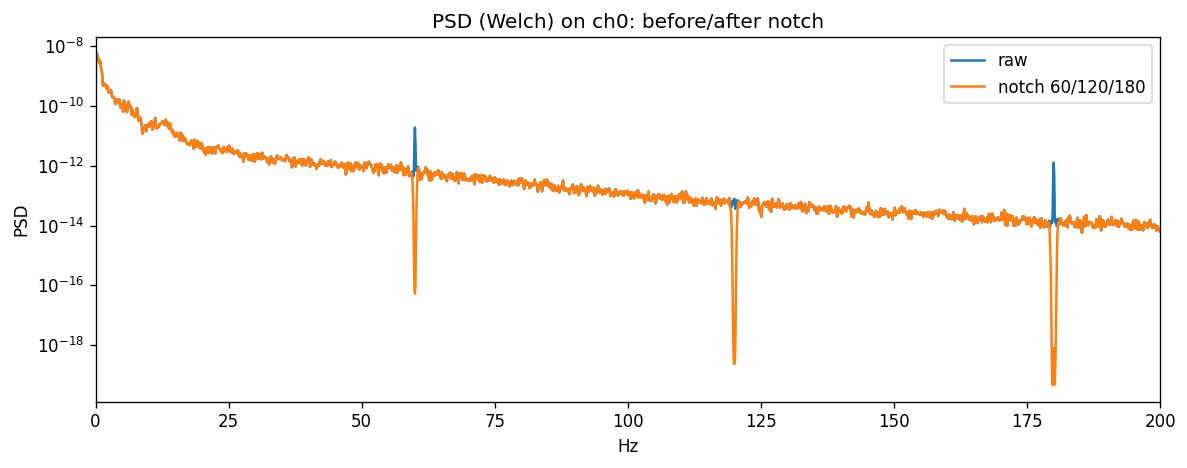

In [16]:
# PSD + notch effect demo on channel 0
if welch is None:
    print('Skip PSD: scipy.signal.welch not available')
else:
    x = data[0]
    f, pxx = welch(x, fs=sfreq, nperseg=int(min(len(x), sfreq*10)))
    
    # Notch at 60Hz + harmonics (if mne is available)
    x_f = x.copy()
    line_freq = 60.0
    freqs = np.array([line_freq, 2*line_freq, 3*line_freq])
    try:
        x_f = mne.filter.notch_filter(x_f, Fs=sfreq, freqs=freqs, verbose='ERROR')
    except Exception as e:
        print('Notch filter failed:', e)
        x_f = x
    f2, pxx2 = welch(x_f, fs=sfreq, nperseg=int(min(len(x_f), sfreq*10)))

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.semilogy(f, pxx + 1e-20, label='raw')
    ax.semilogy(f2, pxx2 + 1e-20, label='notch 60/120/180')
    ax.set_xlim(0, 200)
    ax.set_title('PSD (Welch) on ch0: before/after notch')
    ax.set_xlabel('Hz')
    ax.set_ylabel('PSD')
    ax.legend()
    plt.tight_layout(); plt.show()

## Đọc output: PSD (Welch) trước/sau notch 60Hz



Plot PSD (trục Y log/`semilogy`) cho `ch0` thể hiện rất rõ **line noise**:

- Đường `raw` (xanh) có các “đỉnh nhọn” tại ~**60 Hz** và ~**180 Hz** (và thường cả 120 Hz tuỳ run).

- Đường `notch 60/120/180` (cam) tạo các **notch sâu** đúng tại những tần số này → cho thấy notch filter đang làm việc và loại bỏ thành phần điện lưới.



Cách đọc đúng:

- Nếu sau notch, các đỉnh 60/120/180 giảm mạnh mà nền PSD còn lại gần như giữ nguyên → lọc hợp lý.

- Nếu notch làm “bẹp” cả dải rộng quanh 60Hz (hoặc xuất hiện ringing) → cần cân nhắc tham số/notch bandwidth.



Hàm ý cho seizure detection:

- Line noise thường là nguồn bias lớn cho các feature phổ; nên hoặc notch trước khi trích feature, hoặc dùng feature/bandpower tránh đúng các harmonic (ví dụ bỏ quanh 60±1 Hz).

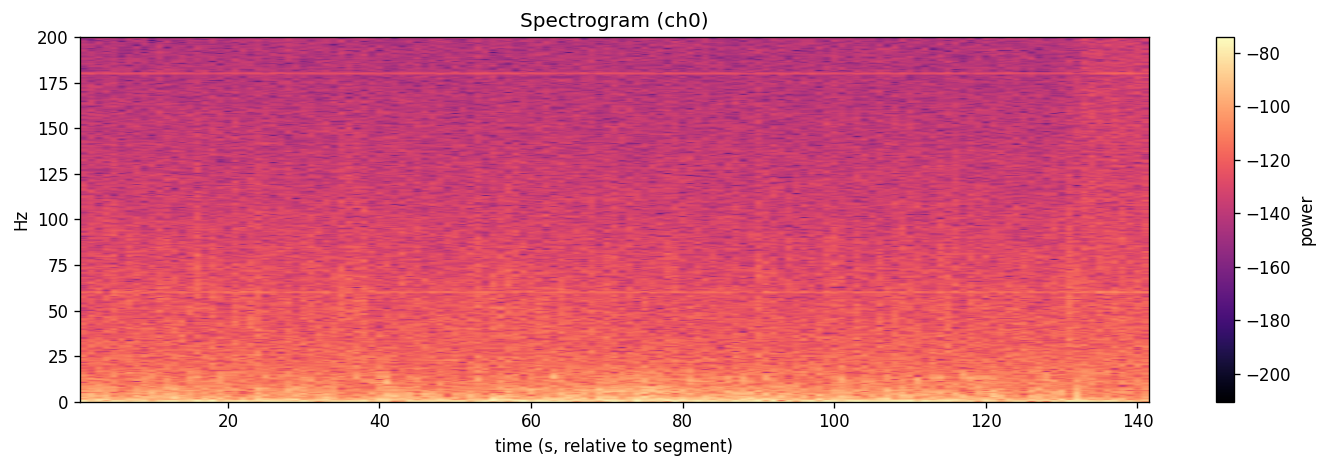

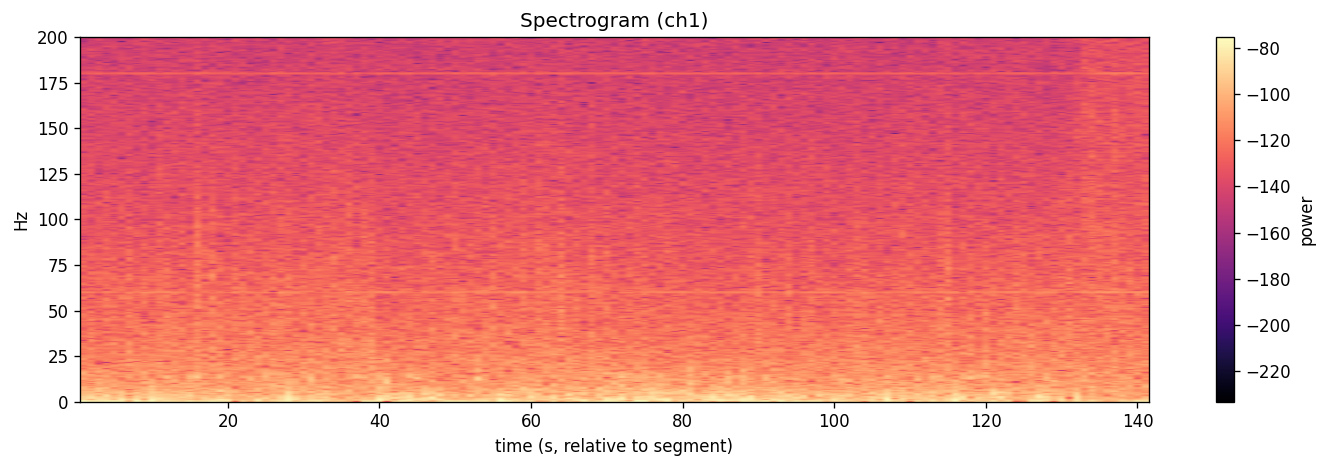

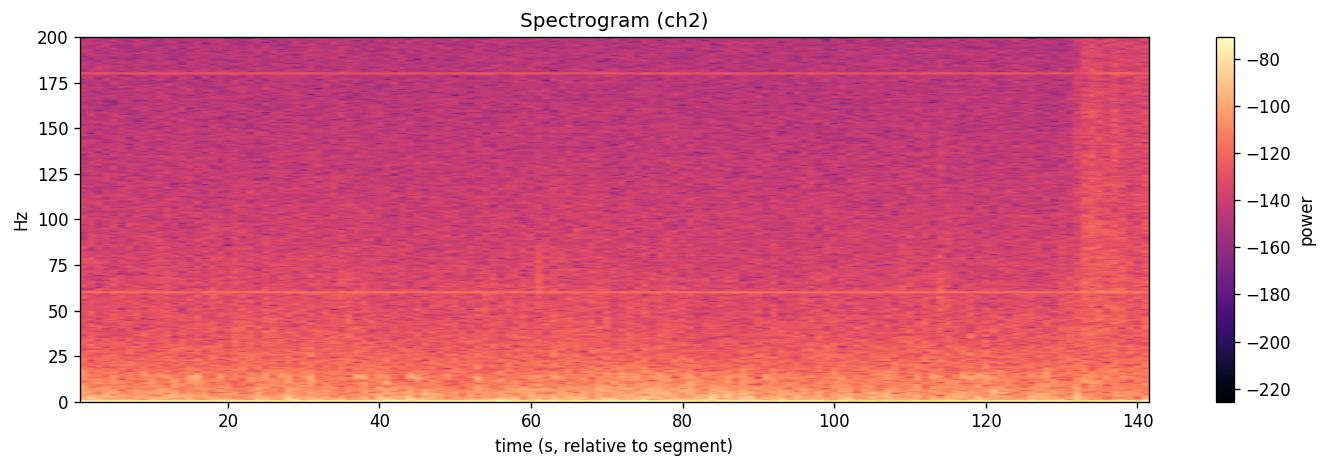

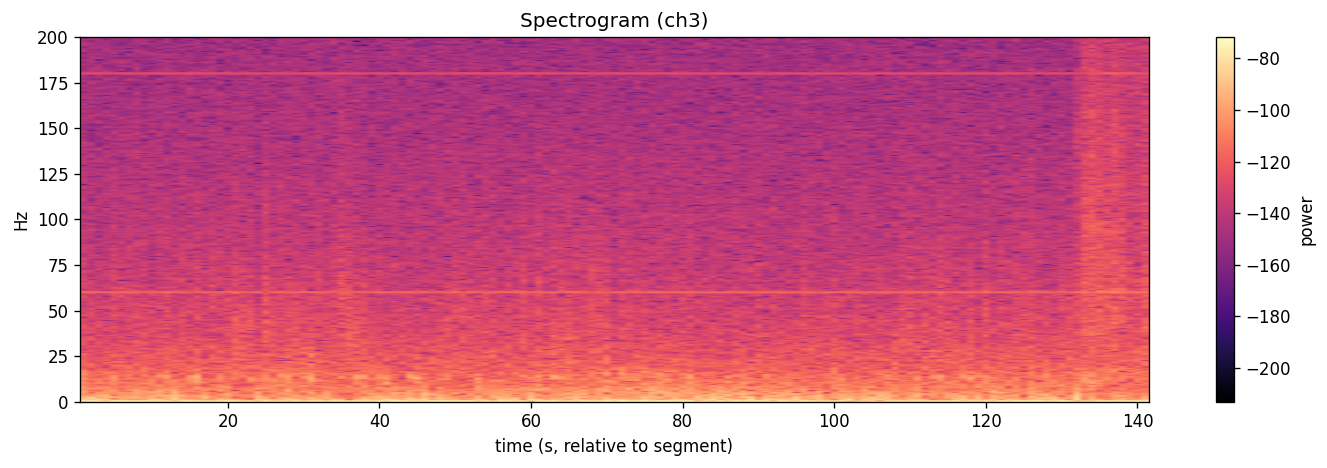

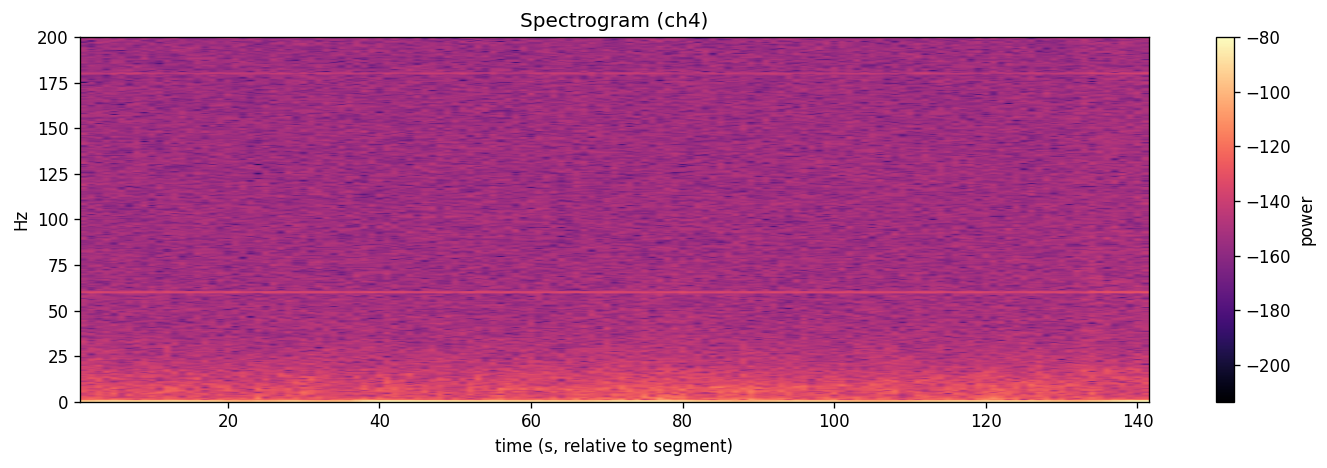

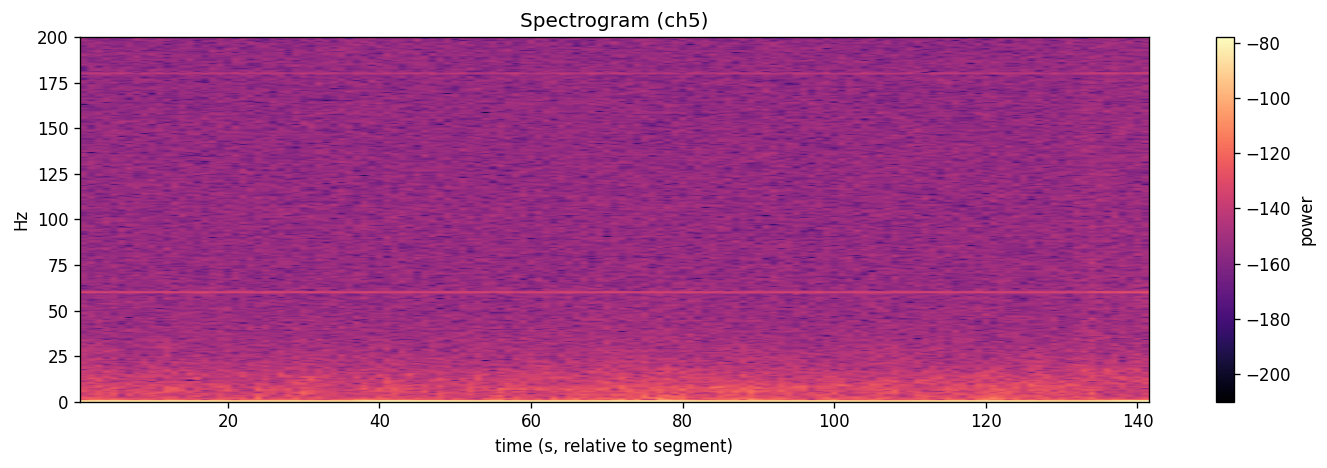

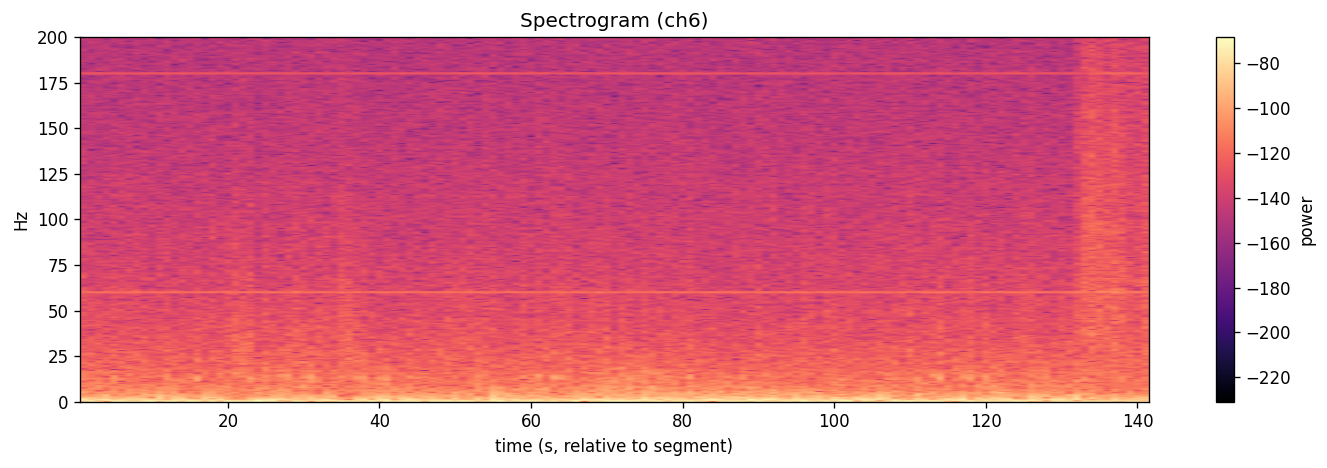

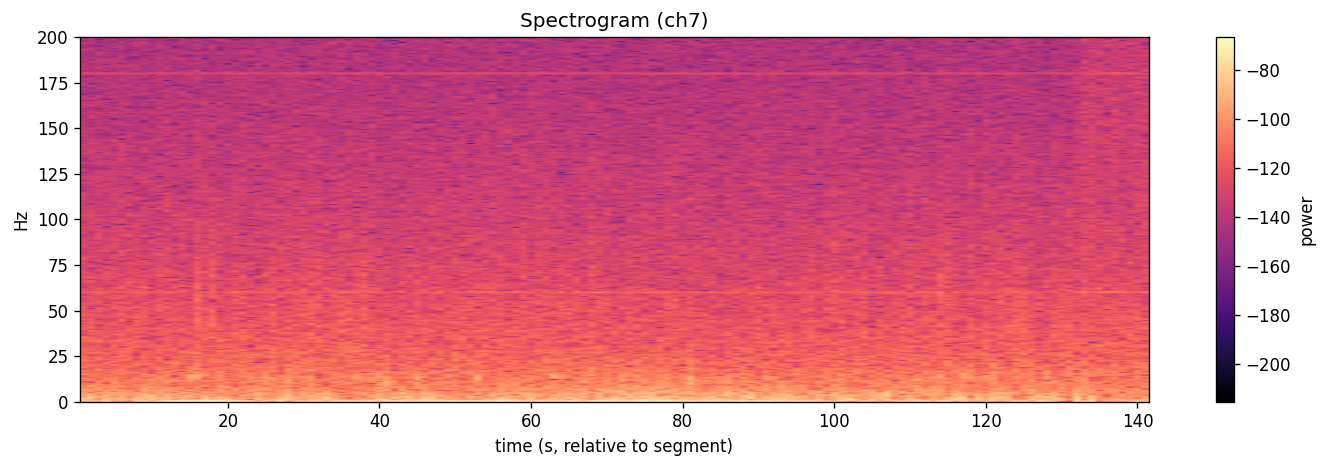

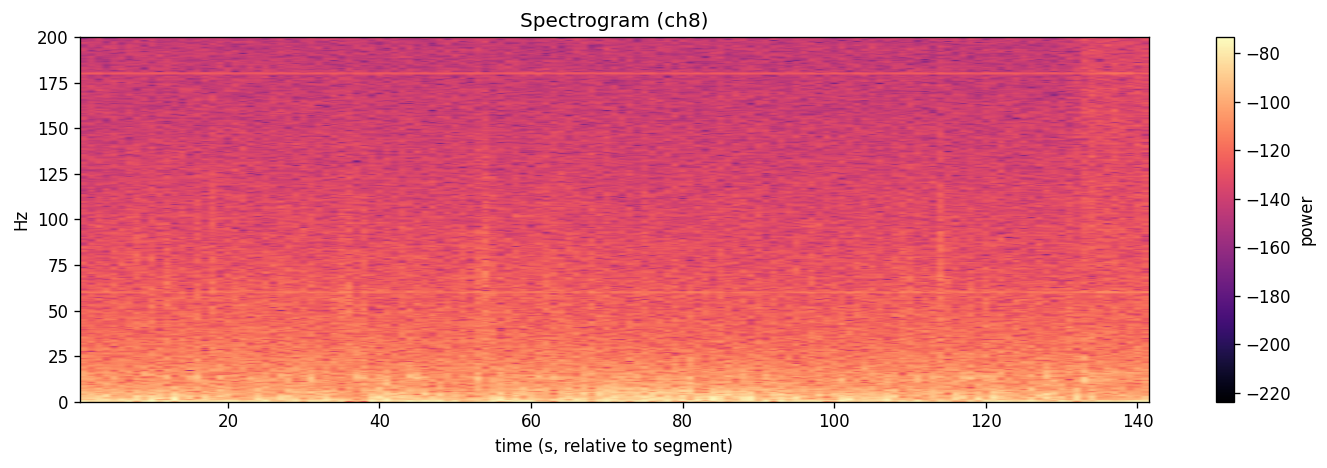

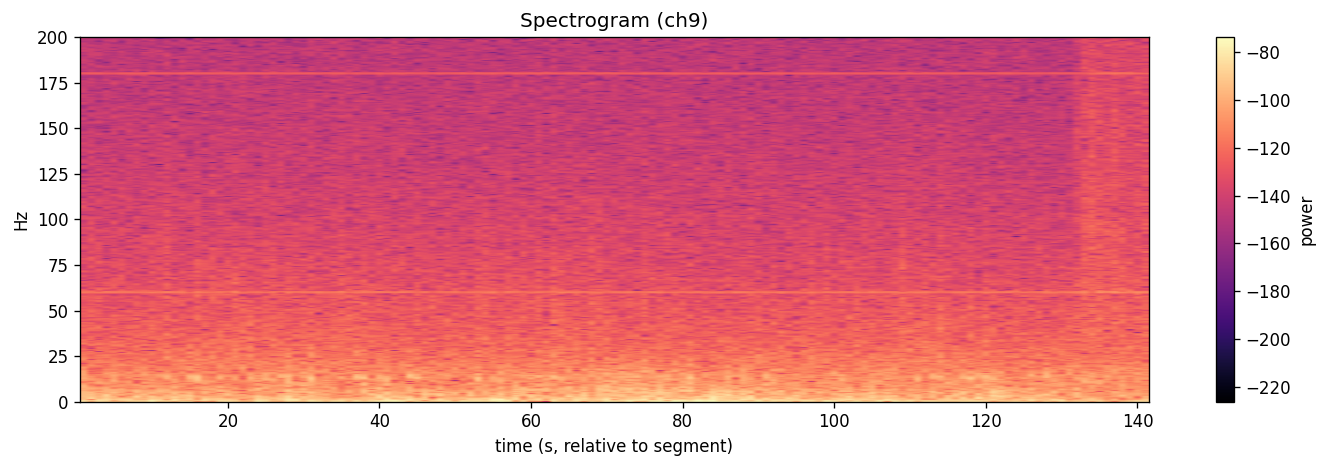

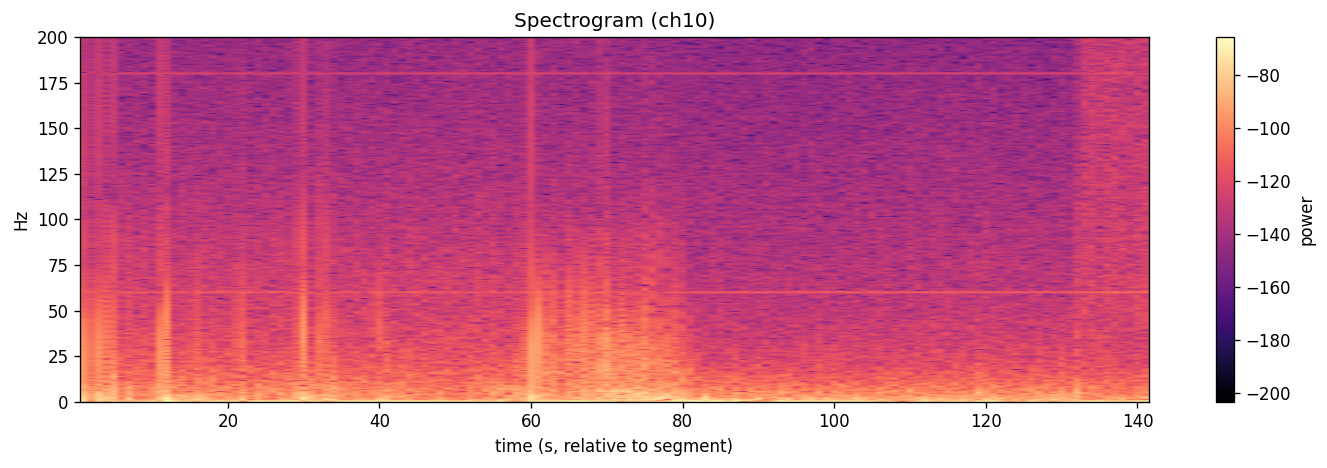

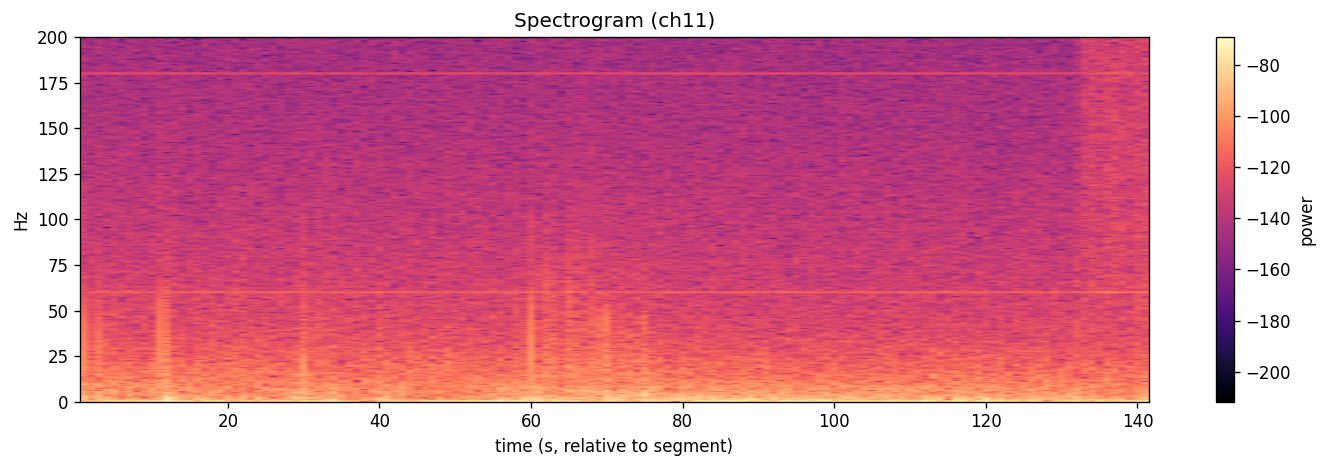

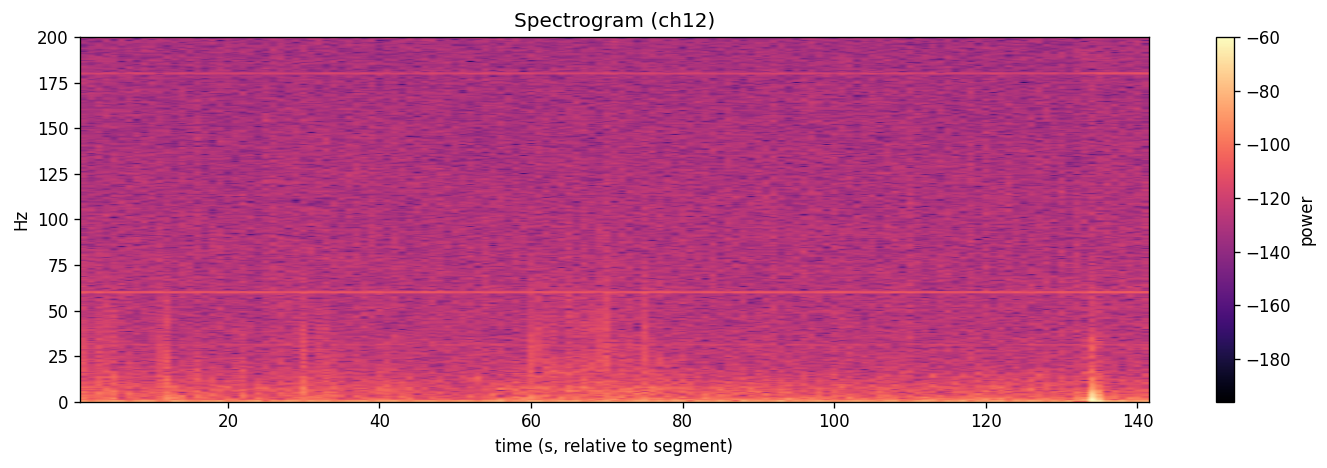

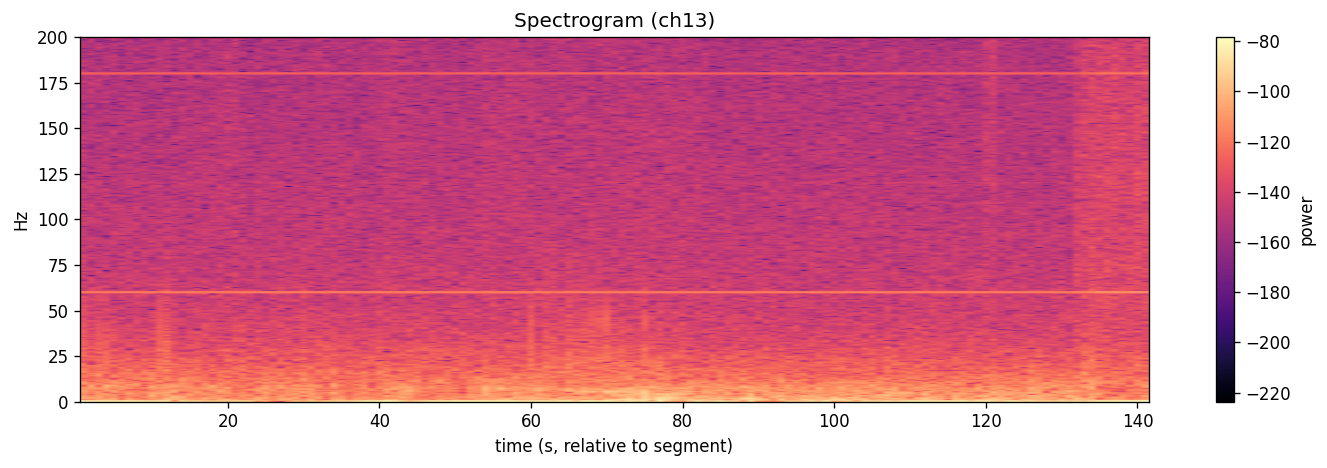

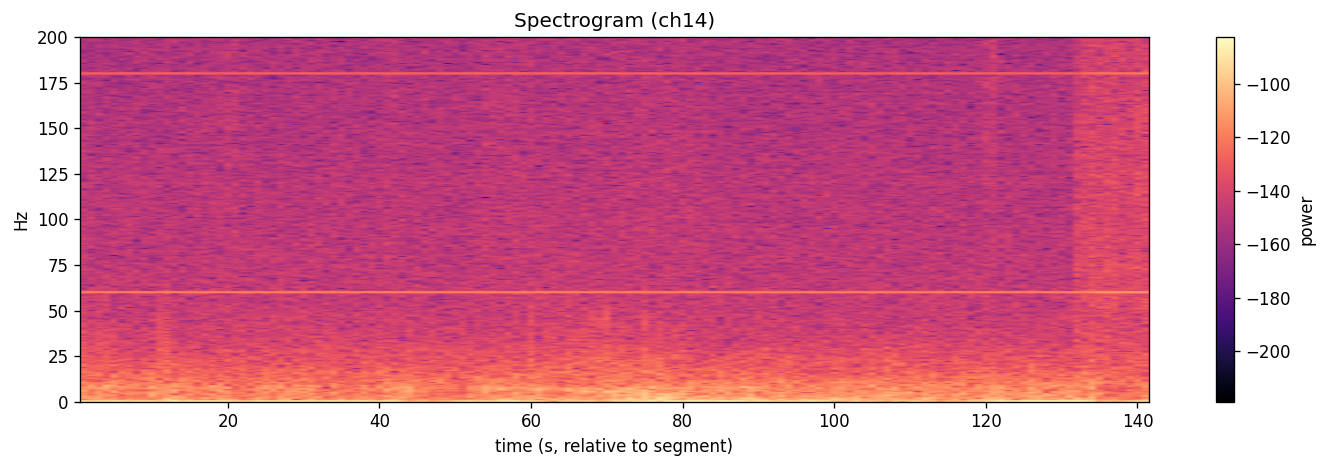

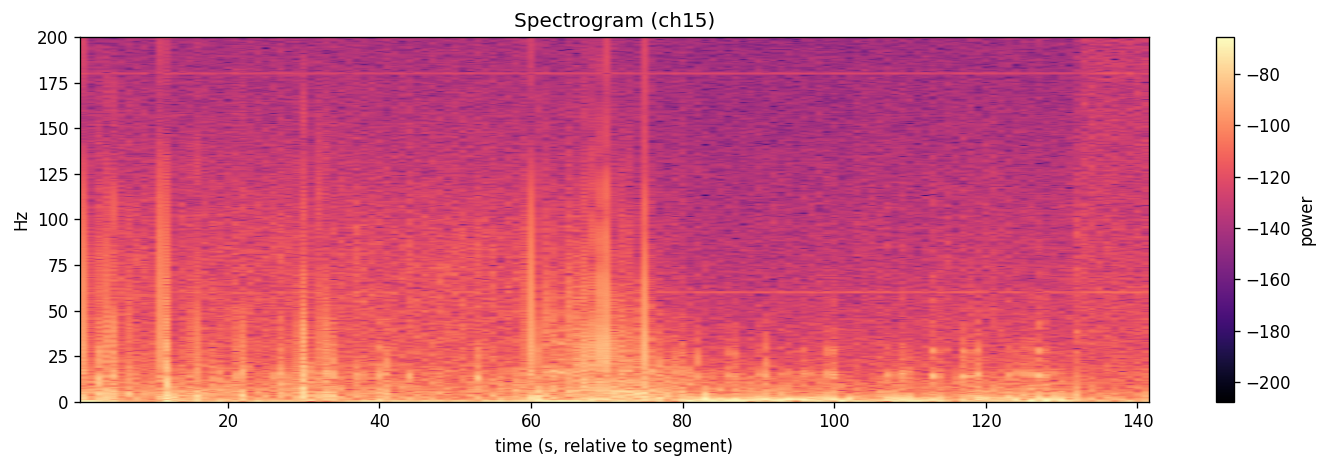

In [17]:
# Spectrogram around seizure (channel 0)
for i in range(0,16):
    x = data[i]
    fig, ax = plt.subplots(figsize=(12, 4))
    Pxx, freqs, bins, im = ax.specgram(x, NFFT=int(sfreq*2), Fs=sfreq, noverlap=int(sfreq*1), cmap='magma')
    ax.set_ylim(0, 200)
    ax.set_title(f'Spectrogram (ch{i})')
    ax.set_xlabel('time (s, relative to segment)')
    ax.set_ylabel('Hz')
    plt.colorbar(im, ax=ax, label='power')
    plt.tight_layout(); plt.show()

## Đọc output: Spectrogram (ch0)



Spectrogram là bản đồ **time–frequency** (0–200 Hz):

- Trục X: thời gian **tương đối so với segment** (0–~142s).

- Trục Y: tần số (Hz).

- Màu: power (độ sáng hơn = công suất cao hơn).



Với run này, seizure interval nằm khoảng **59–80s** trên trục X (vì segment bắt đầu từ t0=0). Khi đọc hình:

- Nhìn xem trong khoảng 59–80s có tăng power ở dải nào (low freq, beta/gamma) hoặc xuất hiện “ridge”/band mới.

- Nếu không thấy khác biệt rõ trên ch0, có thể do:

  - seizure biểu hiện mạnh ở kênh khác (không phải ch0)

  - hoặc seizure chủ yếu thay đổi hình thái (spike/line length) hơn là tăng bandpower rõ ràng.



Gợi ý cải thiện (nếu cần): vẽ spectrogram cho vài kênh có RMS/PTP cao, hoặc dùng median spectrogram qua nhiều kênh để đỡ phụ thuộc vào ch0.

In [30]:
# Feature trajectories (RMS, line length, Hjorth, bandpower) with interval overlay
WINDOW_SEC = 2.0
STEP_SEC = 1.0

def line_length(x: np.ndarray) -> float:
    dx = np.diff(x)
    return float(np.nansum(np.abs(dx)))

def bandpower(x: np.ndarray, fs: float, fmin: float, fmax: float) -> float:
    if welch is None:
        return float('nan')
    f, pxx = welch(x, fs=fs, nperseg=int(min(len(x), fs * 2)))
    mask = (f >= fmin) & (f <= fmax)
    if not np.any(mask):
        return float('nan')
    # np.trapz may warn about deprecation in some versions; ok for now
    return float(np.trapz(pxx[mask], f[mask]))

def hjorth_params(x: np.ndarray) -> tuple[float, float, float]:
    """Return Hjorth (activity, mobility, complexity) for a 1D signal."""
    x = np.asarray(x, dtype=float)
    if x.size < 3:
        return float('nan'), float('nan'), float('nan')
    x = x[np.isfinite(x)]
    if x.size < 3:
        return float('nan'), float('nan'), float('nan')
    dx = np.diff(x)
    ddx = np.diff(dx)
    var_x = float(np.var(x))
    var_dx = float(np.var(dx))
    var_ddx = float(np.var(ddx))
    activity = var_x
    if var_x <= 0 or not np.isfinite(var_x) or not np.isfinite(var_dx):
        return activity, float('nan'), float('nan')
    mobility = float(np.sqrt(var_dx / var_x))
    if var_dx <= 0 or not np.isfinite(var_ddx) or not np.isfinite(mobility) or mobility == 0:
        return activity, mobility, float('nan')
    mobility_dx = float(np.sqrt(var_ddx / var_dx))
    complexity = float(mobility_dx / mobility) if np.isfinite(mobility_dx) else float('nan')
    return activity, mobility, complexity

# Compute trajectories using channel-mean features across picked channels
w = int(WINDOW_SEC * sfreq)
step = int(STEP_SEC * sfreq)
starts = list(range(0, T - w + 1, step))
t_mid = []
rms_tr = []
ll_tr = []
bp_gamma_tr = []  # 30-80 on ch0
hj_act_tr = []
hj_mob_tr = []
hj_comp_tr = []

for s in starts:
    e = s + w
    win = data[:, s:e]
    # mean over channels
    rms_tr.append(float(np.sqrt(np.nanmean(win**2))))
    ll_tr.append(float(np.nanmean([line_length(win[i]) for i in range(win.shape[0])])))

    acts, mobs, comps = [], [], []
    for i in range(win.shape[0]):
        a, m, c = hjorth_params(win[i])
        acts.append(a)
        mobs.append(m)
        comps.append(c)
    hj_act_tr.append(float(np.nanmean(acts)))
    hj_mob_tr.append(float(np.nanmean(mobs)))
    hj_comp_tr.append(float(np.nanmean(comps)))

    bp_gamma_tr.append(float(bandpower(win[0], sfreq, 30, 80)))
    t_mid.append(float(times[s:e].mean()))

traj = pd.DataFrame({
    't': t_mid,
    'rms': rms_tr,
    'line_length': ll_tr,
    'hj_activity': hj_act_tr,
    'hj_mobility': hj_mob_tr,
    'hj_complexity': hj_comp_tr,
    'bp_30_80_ch0': bp_gamma_tr,
})
traj.describe()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25812\3634744105.py:17: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(pxx[mask], f[mask]))


t         rms  line_length   hj_activity  hj_mobility  \
count  141.000000  141.000000   141.000000  1.410000e+02   141.000000   
mean    70.999500    0.000134     0.004850  8.682561e-09     0.094769   
std     40.847277    0.000028     0.001004  6.804823e-09     0.026046   
min      0.999500    0.000082     0.003683  8.829439e-10     0.051647   
25%     35.999500    0.000113     0.004148  4.488130e-09     0.077575   
50%     70.999500    0.000130     0.004508  7.406367e-09     0.091847   
75%    105.999500    0.000151     0.005257  1.140074e-08     0.109101   
max    140.999500    0.000237     0.008889  5.020420e-08     0.179899   

       hj_complexity  bp_30_80_ch0  
count     141.000000  1.410000e+02  
mean       14.646325  4.715695e-11  
std         3.896365  1.788636e-11  
min         6.140937  2.370323e-11  
25%        11.688084  3.462043e-11  
50%        14.792665  4.247334e-11  
75%        17.321699  5.858012e-11  
max        25.831472  1.505789e-10

## Đọc output: Feature trajectories được tính như thế nào?


Cell này tạo bảng `traj` bằng cách trượt cửa sổ với:

- `WINDOW_SEC = 2.0s`, `STEP_SEC = 1.0s` → các điểm trên đường là đặc trưng của mỗi window 2 giây, cách nhau 1 giây.
- `traj['t']` là **thời gian trung điểm** của window (absolute recording time).


Các feature đang dùng:

- `rms`: RMS **mean trên tất cả kênh đã pick** (16 kênh).
- `line_length`: line length **mean trên các kênh** (nhạy với spike/hoạt động nhanh).
- `hj_activity`, `hj_mobility`, `hj_complexity`: Hjorth parameters **mean trên các kênh** để mô tả động học tín hiệu theo thời gian:
  - activity ~ variance/energy (gần với RMS^2)
  - mobility ~ độ “nhanh” (tỷ lệ năng lượng đạo hàm bậc 1 so với tín hiệu gốc)
  - complexity ~ mức “phức tạp”/thay đổi của mobility (tỷ lệ mobility của dx so với mobility của x)
- `bp_30_80_ch0`: bandpower 30–80Hz **chỉ trên ch0** (nhạy nhưng phụ thuộc kênh).


Cảnh báo nhỏ: Warning `trapz is deprecated` chỉ là cảnh báo của NumPy/SciPy về hàm tích phân; không ảnh hưởng ý nghĩa plot (có thể thay `np.trapz` bằng `np.trapezoid` để sạch log nếu muốn).

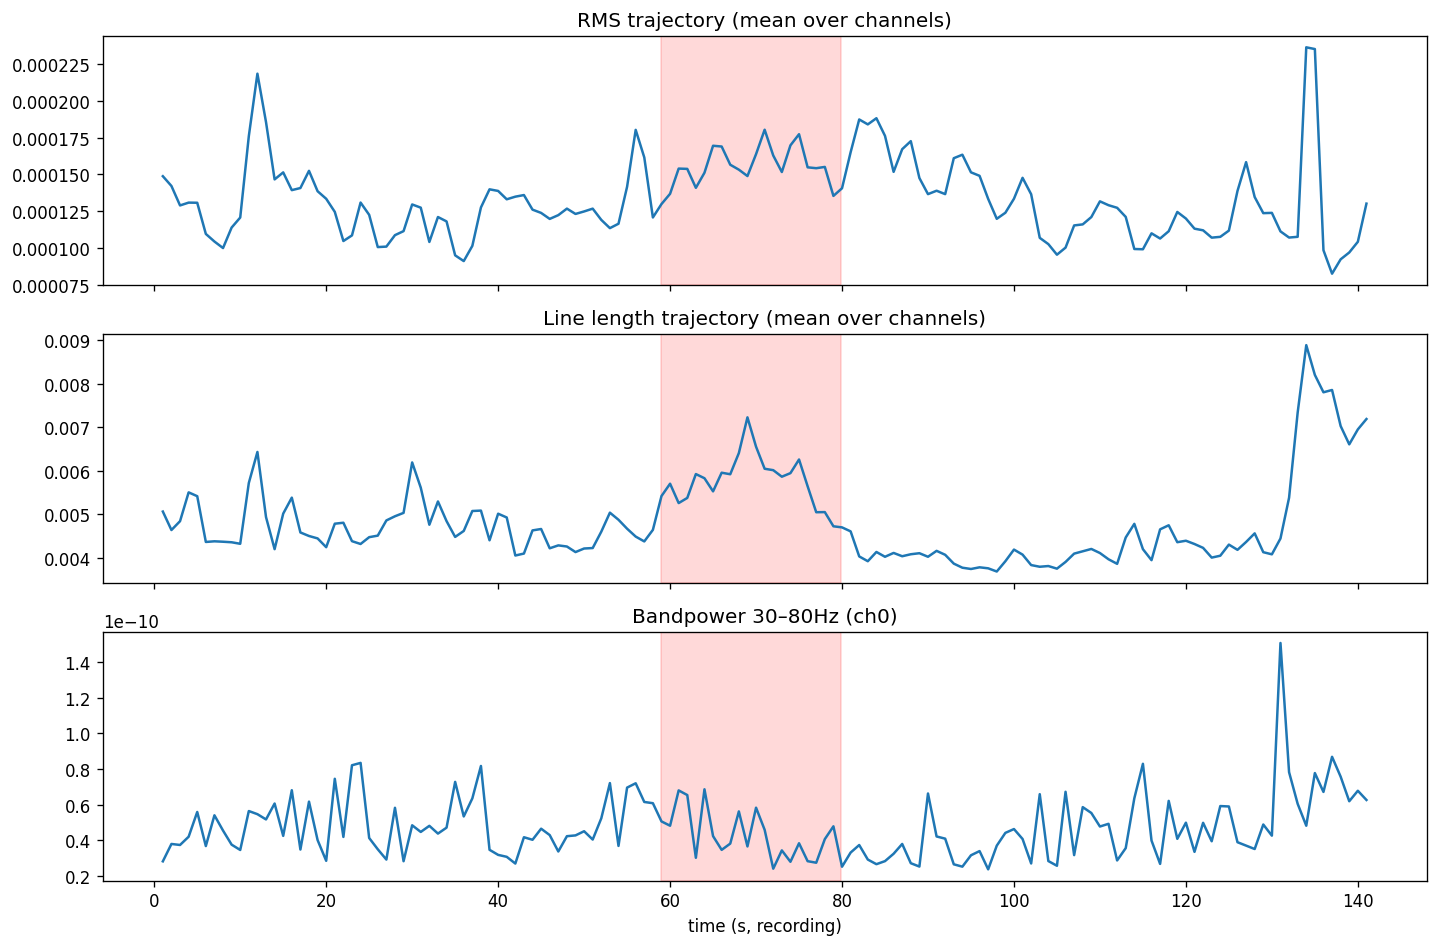

In [ ]:
def shade_intervals(ax, run_intervals_df: pd.DataFrame, t0_offset: float = 0.0, alpha: float = 0.15):
    # run_intervals are in absolute seconds (recording time). Our times are already absolute.
    for _, rr in run_intervals_df.iterrows():
        ax.axvspan(float(rr['onset_s']), float(rr['offset_s']), color='red', alpha=alpha)

fig, axes = plt.subplots(6, 1, figsize=(12, 12), sharex=True)

axes[0].plot(traj['t'], traj['rms'])
shade_intervals(axes[0], run_intervals)
axes[0].set_title('RMS trajectory (mean over channels)')

axes[1].plot(traj['t'], traj['line_length'])
shade_intervals(axes[1], run_intervals)
axes[1].set_title('Line length trajectory (mean over channels)')

axes[2].plot(traj['t'], traj['hj_activity'])
shade_intervals(axes[2], run_intervals)
axes[2].set_title('Hjorth activity trajectory (mean over channels)')

axes[3].plot(traj['t'], traj['hj_mobility'])
shade_intervals(axes[3], run_intervals)
axes[3].set_title('Hjorth mobility trajectory (mean over channels)')

axes[4].plot(traj['t'], traj['hj_complexity'])
shade_intervals(axes[4], run_intervals)
axes[4].set_title('Hjorth complexity trajectory (mean over channels)')

axes[5].plot(traj['t'], traj['bp_30_80_ch0'])
shade_intervals(axes[5], run_intervals)
axes[5].set_title('Bandpower 30–80Hz (ch0)')
axes[5].set_xlabel('time (s, recording)')

plt.tight_layout(); plt.show()

## Đọc output: Trajectory + vùng tô đỏ (seizure interval)



Trong hình 3-panel bạn đang thấy:

- Vùng **tô đỏ** chính là seizure interval (≈ 58.95–79.875s) lấy từ `events.tsv`.

- Trục X là **time (s, recording)** nên shading khớp trực tiếp với onset/offset.



Diễn giải theo hình hiện tại:

- **RMS** có xu hướng **tăng trong vùng tô đỏ** so với baseline trước đó → năng lượng tín hiệu tăng trong seizure (phù hợp trực giác).

- **Line length** tăng rõ trong vùng đỏ và sau đó giảm/ổn định lại → đặc trưng này thường nhạy với spike/rhythmic activity, hay hữu ích cho phát hiện ictal.

- **Bandpower 30–80Hz (ch0)** trong vùng đỏ không tăng nổi bật, nhưng có **spike rất lớn** gần cuối segment (~130–140s) *ngoài seizure* → nhiều khả năng là artifact hoặc hoạt động cục bộ mạnh không phải seizure.



Gợi ý đọc đúng kết luận:

- Nếu spike lớn nằm ngoài seizure (như hình), bandpower đơn kênh có thể tạo false positive → nên dùng median/mean qua nhiều kênh, hoặc thêm feature “consensus across channels”.

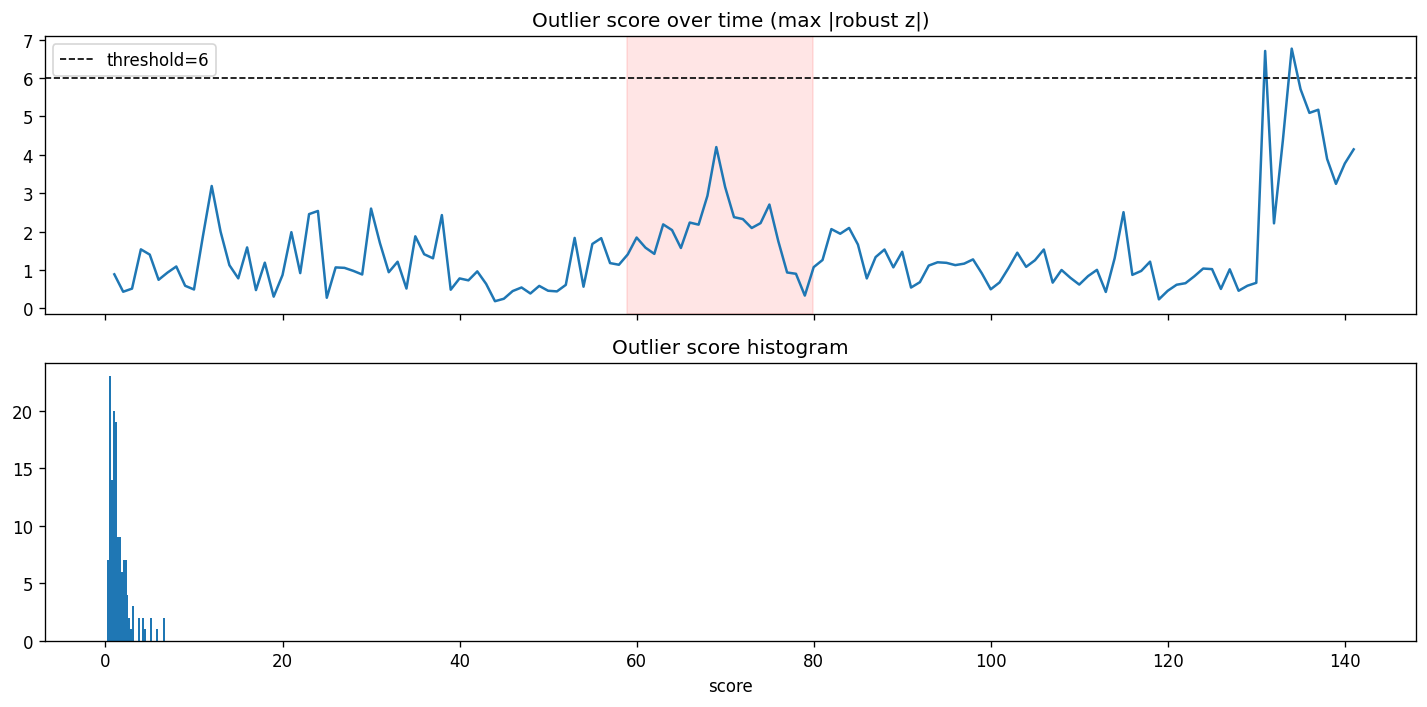

outlier windows rate (>=6): 0.014184397163120567


In [ ]:
# Outlier window scoring (robust z) over trajectories

def robust_z(x: np.ndarray) -> np.ndarray:

    x = np.asarray(x, dtype=float)

    med = np.nanmedian(x)

    mad = np.nanmedian(np.abs(x - med))

    if not np.isfinite(mad) or mad == 0:

        return (x - med) * 0.0

    return 0.6745 * (x - med) / mad



z_rms = robust_z(traj['rms'].values)

z_ll = robust_z(traj['line_length'].values)

z_bp = robust_z(traj['bp_30_80_ch0'].values)

outlier_score = np.nanmax(np.vstack([np.abs(z_rms), np.abs(z_ll), np.abs(z_bp)]), axis=0)



fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axes[0].plot(traj['t'], outlier_score)

shade_intervals(axes[0], run_intervals, alpha=0.10)

axes[0].axhline(6, color='k', ls='--', lw=1, label='threshold=6')

axes[0].set_title('Outlier score over time (max |robust z|)')

axes[0].legend()



axes[1].hist(outlier_score[np.isfinite(outlier_score)], bins=30)

axes[1].set_title('Outlier score histogram')

axes[1].set_xlabel('score')



plt.tight_layout(); plt.show()



rate = float(np.mean(outlier_score >= 6))

print('outlier windows rate (>=6):', rate)


## Đọc output: Outlier score (max |robust z|) và ý nghĩa con số `rate`



Cell này gom 3 trajectory (`rms`, `line_length`, `bp_30_80_ch0`) thành một **outlier score**:

- Với mỗi feature, tính robust-z dựa trên median/MAD.

- `outlier_score = max(|z_rms|, |z_ll|, |z_bp|)` theo từng window.



Trong output hiện tại:

- Đường outlier score có các spike lớn ở cuối segment (~130–140s) và **vượt ngưỡng 6**.

- Vùng đỏ (seizure) không phải nơi outlier score lớn nhất → tức là “cái bất thường nhất” theo 3 feature này lại nằm **ngoài seizure**, gợi ý artifact/đoạn nhiễu.

- `outlier windows rate (>=6): 0.01418` → khoảng **1.4% windows** bị coi là outlier theo ngưỡng 6.



Cách dùng trong pipeline:

- Bạn có thể dùng outlier score như một bước QC: loại hoặc down-weight các windows outlier trước khi train.

- Đừng dùng outlier score làm nhãn seizure; nó chỉ nói “khác thường” chứ không biết đó là ictal hay artifact.

## 7) Multi-seizure example (pick a run with >=2 intervals)

In [21]:
multi_candidates = per_run_int[per_run_int['n_intervals'] >= 2].sort_values('n_intervals', ascending=False)
multi_candidates.head(10)

Empty DataFrame
Columns: [base, n_intervals]
Index: []

## Đọc output: Multi-seizure example (vì sao đang trống?)



Cell `multi_candidates.head(10)` hiện trả về **bảng rỗng** và cell sau in:

- `No multi-interval runs found in intervals CSV`



Điều này nghĩa là với dữ liệu interval mà notebook đang dùng ở thời điểm bạn chạy:

- `per_run_int` không có run nào có `n_intervals >= 2`, hoặc

- `intervals_clean`/`per_run_int` đang được tạo theo cách chỉ giữ **một interval/run** (ví dụ chỉ lấy “first onset + first offset”), hoặc

- bạn đang làm việc trên subset của intervals CSV không chứa multi-interval.



Nếu bạn muốn demo multi-seizure chạy được, cách nhanh nhất là:

- kiểm tra lại file `eda_outputs/ds003029_seizure_intervals_by_run.csv` có run nào lặp `base` nhiều dòng không (>=2 intervals),

- rồi set `base2` theo một run đó (và đảm bảo `.vhdr` tồn tại local).

In [22]:
# If there is a multi-interval run AND its vhdr exists locally, visualize it
if len(multi_candidates) == 0:
    print('No multi-interval runs found in intervals CSV')
else:
    base2 = str(multi_candidates.iloc[0]['base'])
    paths2 = base_to_paths(base2)
    if not Path(paths2['vhdr']).exists():
        print('Multi-interval base found, but vhdr not present locally:', base2)
    else:
        raw2 = mne.io.read_raw_brainvision(Path(paths2['vhdr']), preload=False, verbose='ERROR')
        run_intervals2 = intervals_clean[intervals_clean['base'] == base2].sort_values('onset_s')
        t0_2 = max(0.0, float(run_intervals2['onset_s'].min()) - PRE_SEC)
        t1_2 = min(raw2.times[-1], float(run_intervals2['offset_s'].max()) + POST_SEC)
        seg2 = raw2.copy().crop(tmin=t0_2, tmax=t1_2).load_data()
        sf2 = float(seg2.info['sfreq'])
        seg2.pick(list(range(min(MAX_CHANNELS, len(seg2.ch_names)))))
        d2 = seg2.get_data()
        tt2 = seg2.times + t0_2
        print('Multi-interval base:', base2)
        display(run_intervals2)
        
        # quick RMS trajectory with shading
        w2 = int(WINDOW_SEC * sf2)
        step2 = int(STEP_SEC * sf2)
        starts2 = list(range(0, d2.shape[1] - w2 + 1, step2))
        tmid2, rms2 = [], []
        for s in starts2:
            e = s + w2
            win = d2[:, s:e]
            rms2.append(float(np.sqrt(np.nanmean(win**2))))
            tmid2.append(float(tt2[s:e].mean()))
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.plot(tmid2, rms2)
        shade_intervals(ax, run_intervals2)
        ax.set_title('Multi-interval example: RMS trajectory with ictal interval shading')
        ax.set_xlabel('time (s, recording)')
        plt.tight_layout(); plt.show()

No multi-interval runs found in intervals CSV
